# Take-Home Exam Week 5 INFOMCDMMC 2022/2023

Student number: 7590423 (Albert Cort Banke)

**For this assignment, I aim to do the following when answering all questions.**
1) Provide legible code with comments to help guide my process when answering the question
2) Provide a visualization when applicable to substantiate my answer
3) Provide paragraphs and referencing to support claims and arguments made for each question

The aim is also to complete this assignment in the most pythonic way possible by writing DRY (don't-repeat-yourself) code and
using package's capabilities to the fullest.

In [238]:
# Installing required packages and modules

In [239]:
%pip install kneed 
%pip install wordcloud
%pip install gensim

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [240]:
# Import the required packages for all questions (1-2-3-4)

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud

from collections import Counter
from scipy.stats import chi2_contingency
import re
from kneed import KneeLocator

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

import sklearn
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import spacy

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/albertcortbanke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/albertcortbanke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertcortbanke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/albertcortbanke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/albertcortbanke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [241]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Task One (10 points)

## Question 1.1

**Q: Identifying the most discussed show for each year**

Loading data and preprocessing the data frame and text columns

In [242]:
# Import the dataset (.csv) for the question

path = r'/Users/albertcortbanke/Desktop/Q1_discussions.csv'

reddit_tv = pd.read_csv(path, index_col=0)

# To begin with a quick exploratory analysis of the dataset is to check the state of the data 
# (missing values, wrong format, non-unique values etc.) 

# Inspect the head of the dataset to see whether the dataset has been loaded correctly

reddit_tv.head()

# The data looks good - let us dig a bit deeper and inspect the object types and their integrity, dimensionality and completeness

,title,type,year,post
0,Better Call Saul,linear,2017,Walter. And there the chain ends.
1,Better Call Saul,linear,2016,"I love this show. But it's hard to argue against its pace. It's sooooooooooo slooooowww. The writing, the acting, the direction, the production, all of it top notch. That however, doesn't mean we can't complain it's ""boring"". It's a different kind of boring, but I totally get the critique and I feel the same way. The story takes way too long to develop. It's great to have slower paced TV, but I think this show over does it. \n\nI think it'd be less of a problem if we didn't get only 10 episo..."
2,Better Call Saul,linear,2017,What am I missing? A lot of reference to ribs on a burger.....Is this from a Carls Jr./Hardee's commercial or something?
3,Better Call Saul,linear,2018,"Oh come on Mike, he's a good little boy."
4,Better Call Saul,linear,2017,Look again 👀


In [243]:
# 2) Check the state of the data with the .info() method

reddit_tv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   50000 non-null  object
 1   type    49997 non-null  object
 2   year    50000 non-null  int64 
 3   post    50000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


For the data types; title, type and post are all objects (text). This is good, as we expect them to be this kind of object. The year column is int64 (integer number) - which is fine as well.

The dimensionality is 3 (excluding the index) x 50000, which means the dataset contains 3 columns and 50000 rows. All columns but 'type' are complete, meaning they do not have any missing values. 'type' has 3 missing values. However, since this column is not used in the analysis it is preferable to drop the column

In [244]:
# Using Pandas slicer function we can see that when the title = 'The Crown' there are 335 value counts for type and all of them are 'netflix'

print(reddit_tv[reddit_tv['title'] == 'The Crown']['type'].value_counts()) # prints netflix 335

# But since the column is not used for analysis it is preferable to drop it 

reddit_tv = reddit_tv.drop(columns = ['type'])

netflix    335
Name: type, dtype: int64


In [245]:
# Checking the .info() again to see if the transformation is correct

reddit_tv.info() #50000 non-null objects for type now - it worked

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   50000 non-null  object
 1   year    50000 non-null  int64 
 2   post    50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [246]:
# Now, based on the provided data, the analysis identifies the most discussed show for each year

# Group by year and title and count the number of occurrences of each title
rddt_year_title = reddit_tv.groupby(['year', 'title'])['title'].count().reset_index(name="count")

# Sort values by year in ascending order and count in descending order
rddt_year_title = rddt_year_title.sort_values(by=['year', 'count'], ascending=[True, False])

# Select the first occurence (highest counted show) for each year 
rddt_year_title = rddt_year_title.groupby(['year']).first().reset_index()

# The most discussed show for each year
rddt_year_title

# Breaking Bad and Game of Thrones dominate the list, with 3 appearances each

,year,title,count
0,2011,Breaking Bad,588
1,2012,Breaking Bad,3208
2,2013,Breaking Bad,2627
3,2014,True Detective,563
4,2015,Game of Thrones,4559
5,2016,Game of Thrones,6313
6,2017,Game of Thrones,3903
7,2018,Black Mirror,2427
8,2019,Stranger Things,1450
9,2020,Dark,1458


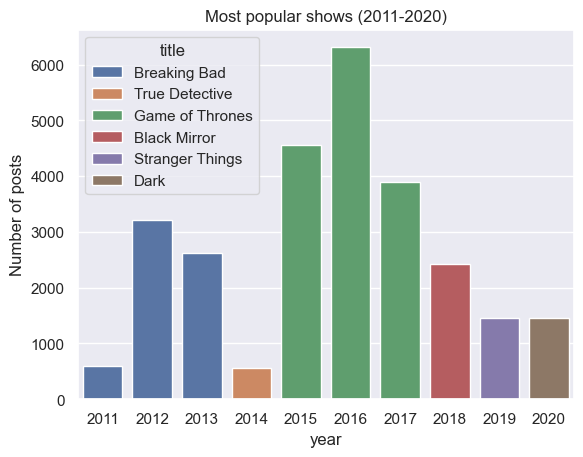

In [247]:
# A graphical overview helps showcase the above answer

# Using seaborn to plot the counts over years with titles as the legend (hue)

# Set to seaborn default theme
sns.set_theme()

# Use the barplot to visualize the most popular show's per year
ax1 = sns.barplot(data=rddt_year_title, x='year', y='count', hue = 'title', dodge=False)
ax1.set_title('Most popular shows (2011-2020)')
ax1.set_ylabel('Number of posts')

plt.show()

The graph reveal two interesting features about the data.
1) The least discussed show of them all which still made the chart was True Detective in 2014. This makes sense as Breaking Bad had ended the year prior, and Game of Thrones was in hiatus for that year

2) Had we included the producer, one could see that during the past three years of the data (2018-2020) the most discussed show for each year has been produced by Netflix as their trademark 'Netflix Originals' (https://www.imdb.com/list/ls093971121/)

## Question 1.2

**Q2: Select a sub-sample of two shows that you are interested in. First, motivate your choice and state a hypothesis about the differences that you expect to find regarding how the shows are being discussed on Reddit.**

For this question I select Game of Thrones and Breaking Bad as I expect to find significant similarities in the discussion of the shows on Reddit. I also chose them since they have multiple seasons across different years which make the time-series comparative element present for both the shows (Wei, 2013).

The motivation and expectation for these said similarities rests upon their respective ratings and reviews. Both shows are regarded as cultural pillars of modern TV (Sepinwall, 2013)

Similarly, both shows currently have a rating above 9 on IMDb which puts them in the top 20 shows of all time (Chau & Vanderwees, 2019) & (https://www.imdb.com/chart/toptv/)

The hypothesis is that the dicussion of the two shows has strong similarities in Reddit user's choice of adjectives for the shows.  

_______

**The 20 most used adjectives in comments per show:**

In [248]:
# First step is a preprocessing step: Much of the code is inspired by the manual: https://jveerbeek.gitlab.io/data-mining/preprocessing

# The first steps are; using regex to keep only letters (removing all emojis for example), lowercasing the letters and stripping the text of excess whitespace
clean_text = lambda text: re.sub(r'[^\w\s]','',text.lower().strip())

reddit_tv['clean_post'] = reddit_tv['post'].apply(clean_text)

# Set a list of stopwords
stopwords = set(stopwords.words('english'))

def get_adjectives(text):
    # Use NLTK to tokenize and tag the words in the text
    tagged_words = nltk.pos_tag(nltk.word_tokenize(text))

    # Return only the words that are tagged as adjectives and not in the list of stopwords
    return [word for word, pos in tagged_words if pos == 'JJ' and word not in stopwords]


# Apply the function and create the adjectives column using the apply() method
reddit_tv['adjectives'] = reddit_tv['clean_post'].apply(get_adjectives)

# Inspect the data frame and the preprocessing changes. It looks good!
reddit_tv.tail()

,title,year,post,clean_post,adjectives
49995,Twin Peaks,2017,"Anyone else think that the top of the mushroom cloud looked just like the shape of whatever-the-hell-that-is at the top of the ""new Arm""?",anyone else think that the top of the mushroom cloud looked just like the shape of whateverthehellthatis at the top of the new arm,[new]
49996,Twin Peaks,2017,Shit I thought it was mini van lady with shooter kid,shit i thought it was mini van lady with shooter kid,[mini]
49997,Twin Peaks,2017,"Did Janey say that Dougie was absent for a night? If so, then yeah I can swallow that.",did janey say that dougie was absent for a night if so then yeah i can swallow that,[]
49998,Twin Peaks,2017,From what I've read and seen they were mutual fans of each other for decades.,from what ive read and seen they were mutual fans of each other for decades,"[ive, mutual]"
49999,Twin Peaks,2017,PBR... blech!!!,pbr blech,[]


In [249]:
# Subset the data frame into a Breaking Bad frame (breakbad) and a Game of Thrones frame (got)
breakbad = reddit_tv[reddit_tv['title'] == 'Breaking Bad'][['year', 'adjectives']]
got = reddit_tv[reddit_tv['title'] == 'Game of Thrones'][['year', 'adjectives']]

# Use the flatten lambda function from the manual to concat the the lists
flatten = lambda t: [item for sublist in t for item in sublist]

# Find 20 the most occuring adjectives for Game of Thrones
got_tokenized_adj_concat = flatten(got['adjectives'])

got_word_counts = Counter(got_tokenized_adj_concat)
got_word_counts.most_common()[:20] # n = 20

# Answer to 20 most used adjectives in posts for Game of Thrones below

[('good', 465),
 ('dead', 358),
 ('last', 351),
 ('much', 332),
 ('white', 283),
 ('first', 275),
 ('sure', 268),
 ('little', 266),
 ('next', 237),
 ('whole', 232),
 ('bad', 226),
 ('great', 213),
 ('im', 198),
 ('many', 187),
 ('real', 163),
 ('high', 158),
 ('big', 150),
 ('red', 143),
 ('true', 140),
 ('new', 136)]

To exemplify the results, the top three adjectives used to describe Game of Thrones are "good," "dead," and "last." It's interesting to note that some of the enemies in the show are portrayed as undead, or zombies. This suggests that the context in which these adjectives are used may be important, as they may not necessarily be describing the show in a traditional sense. For example, "dead" could be used to refer to a character's fate within the narrative, rather than as a general adjective.

In [250]:
# Removing the word 'bad' from the list of adjectives as having a word from the title of the show is counterintuitive when looking for adjectives describing the show 

breakbad['adjectives'] = breakbad['adjectives'].apply(lambda x: [y for y in x if y != 'bad'])
bb_tokenized_adj = breakbad['adjectives']
bb_tokenized_adj_concat = flatten(bb_tokenized_adj)

bb_word_counts = Counter(bb_tokenized_adj_concat)
bb_word_counts.most_common()[:20] # n = 20

# Answer to 20 most used adjectives in posts for Breaking Bad below

[('good', 145),
 ('much', 132),
 ('last', 127),
 ('first', 108),
 ('sure', 106),
 ('next', 91),
 ('walt', 90),
 ('dead', 80),
 ('new', 76),
 ('whole', 73),
 ('white', 68),
 ('im', 66),
 ('great', 63),
 ('ive', 57),
 ('little', 56),
 ('wrong', 52),
 ('many', 52),
 ('right', 51),
 ('jesse', 49),
 ('gus', 48)]

The top three adjectives used to describe Breaking Bad are "good," "much," and "last." These adjectives show similarities to the list of top adjectives for Game of Thrones. However, what is notable about this list is that the names of characters such as Jesse and Walt have also made it into the top 20 adjectives. This suggests that these characters have a significant impact on people's perceptions of the show (Wei, 2013). 

_______

**The most common adjectives in comments per show over the years 2011-2020:**

In [251]:
# First the analysis finds these adjectives for Game of Thrones 

# Group the data frame by year
grouped = got.groupby("year")

# Initialize the counter to count the occurrences of each adjective
counter = Counter()

# For each year, add the adjectives to the counter
for name, group in grouped:
    for adjectives in group["adjectives"]:
        counter.update(adjectives)

# Get the most common adjectives for each year
most_common = {}
for year, group in grouped:
    year_counter = Counter()
    for adjectives in group["adjectives"]:
        year_counter.update(adjectives)
    most_common[year] = year_counter.most_common(1)

# Print the results
print(f'The most common adjectives for Game of Thrones over time are {most_common}')


The most common adjectives for Game of Thrones over time are {2015: [('good', 160)], 2016: [('good', 175)], 2017: [('good', 113)], 2019: [('first', 26)]}


In [252]:
# Now doing the same for Breaking Bad

# Group the data frame by year
grouped = breakbad.groupby("year")

# Initialize the counter to count the occurrences of each adjective
counter = Counter()

# For each year, add the adjectives to the counter
for name, group in grouped:
    for adjectives in group["adjectives"]:
        counter.update(adjectives)

# Get the most common adjectives for each year
most_common = {}
for year, group in grouped:
    year_counter = Counter()
    for adjectives in group["adjectives"]:
        year_counter.update(adjectives)
    most_common[year] = year_counter.most_common(1)

# Print the results
print(f'The most common adjectives for Breaking Bad over time are {most_common}')

The most common adjectives for Breaking Bad over time are {2011: [('gus', 20)], 2012: [('good', 78)], 2013: [('good', 52)], 2014: []}


_______

**Retrieve the most distinct words per show:**

In [253]:
# Here the function code is used and modified from the manual: https://jveerbeek.gitlab.io/data-mining/frequency/distinctive.html

# Create a Counter object for each corpus
counts_c1 = Counter(got_tokenized_adj_concat) # Flattening the texts 
counts_c2 = Counter(bb_tokenized_adj_concat)

# Find the vocabulary of both corpora (all the unique words in both corpora)
vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))

# Calculate the total frequency of words in each corpus
freq_c1_total = sum(counts_c1.values()) 
freq_c2_total = sum(counts_c2.values()) 

results = []

# Iterate over the vocabulary and perform the analysis on each word
for word in vocabulary:
    if word == 'bad': # Skipping the word bad as we already had it removed form the breakbad corpus
        continue
    
    # Calculate the frequency of the word in each corpus
    freq_c1 = counts_c1[word]
    freq_c2 = counts_c2[word]
    
    freq_c1_other = freq_c1_total - freq_c1
    freq_c2_other = freq_c2_total - freq_c2
    
    # Perform chi-squared test and store the LLR, p-value, and degrees of freedom
    llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                  [freq_c1_other, freq_c2_other]],
                  lambda_='log-likelihood') 
    
    # If the word is more distinctive in corpus 2 than in corpus 1, negate the LLR value
    if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
        llr = -llr
    
    # Store the results in a dictionary and append it to the list
    result = {'word':word, 
                'llr':llr,
                'p_value': p_value}
    results.append(result)

results_df = pd.DataFrame(results)

# Displaying the list of distinctive words for Game of Thrones
results_df.sort_values('llr', ascending=False) 

,word,llr,p_value
3667,arya,61.717694,3.964022e-15
869,sansa,44.785279,2.198695e-11
4031,north,44.785279,2.198695e-11
1561,dany,41.413828,1.231830e-10
3048,stark,36.369034,1.632768e-09
...,...,...,...
2098,hank,-98.110178,3.957395e-23
4282,skylar,-118.881600,1.111711e-27
2863,gus,-127.198908,1.680571e-29
3454,jesse,-129.972714,4.154495e-30


In [254]:
# Reversing the list to display the words for Breaking Bad 
results_df.sort_values('llr', ascending=True) 

,word,llr,p_value
3422,walt,-244.139812,4.921224e-55
3454,jesse,-129.972714,4.154495e-30
2863,gus,-127.198908,1.680571e-29
4282,skylar,-118.881600,1.111711e-27
2098,hank,-98.110178,3.957395e-23
...,...,...,...
3048,stark,36.369034,1.632768e-09
1561,dany,41.413828,1.231830e-10
869,sansa,44.785279,2.198695e-11
4031,north,44.785279,2.198695e-11


The results demonstrate that the most distinctive words in each show are the names of their characters. For Game of Thrones, Arya, North, and Sansa are the top three most distinctive words. These names belong to two of the main characters (Arya and Sansa) and North is a location in the show.

In Breaking Bad, the three most distinctive words are Walt, Jesse, and Gus. These names also belong to the main characters in the show. Notably, the main character of the show, Walt, has the highest frequency, as indicated by the calculation in the code.

There are a few potential ways to improve the methodology used in this analysis. For example, rather than just looking at the frequency of individual words, it might be useful to consider the context in which they are used. This could be done by looking at the words that occur before and after each distinctive word with collocation analysis (Mello, 2002) or by using techniques like word embeddings, such as word2vec or GloVe, to capture the meaning of the words in relation to one another (Chen et al., 2015).


## Question 1.3

**Discuss your observations: point out what we can learn from these analyses but also what their limitations are. What additional analyses would be needed for more insightful results?**

The hypothesis that the discussion of the two shows has strong similarities in Reddit users' choice of adjectives for the shows was not falsified by the analysis, as it revealed high similarity for adjective usage.   

The analysis of the top 20 adjectives reveals similarities between the language used to describe Game of Thrones and Breaking Bad. Words such as "good," "last," and "much" appear in the top 4 adjectives for both shows. However, it is important to consider the context in which these adjectives are used, as they may convey different meanings depending on the Reddit poster's intended emotion (Aman & Szpakowicz, 2007). Using n-grams to analyze the context of words, as Sidorov et al. recommends, could provide a more complete understanding of the language used to describe the shows (Sidorov et al., 2014).

The analysis of top adjectives over time also supports the idea of similarities between the two shows, with "good" being the most commonly used adjective for both. However, relying solely on a narrow set of top adjectives may exclude valuable information about changes in language over time (Xu et al., 2010). Increasing the sample size of top adjectives and ensuring external validity through careful preprocessing, such as stratified sampling (Xu et al., 2010) could mitigate these limitations.

When examining the most distinct words between the two shows, the analysis found that character names and geographical references were the most unique. This may be due to the nature of the Reddit data sample, as the language used by posters may be influenced by their own experiences and perspective (Choi et al., 2015). However, the sampling technique itself should also be considered a limitation, as internet forums may not accurately reflect the full range of language used to describe the shows (Choi et al., 2015). It is important to consider other sources of data, such as focus groups, interviews, or surveys, to ensure the results are representative of the larger population (Choi et al., 2015).

_________

# Task Two (40 points)

## Question 2.1

**With reference to the learning materials from this course, explain how "framing" is defined and operationalized in your analysis.**

Media framing, as defined by Entman and synthesized by the authors of "Media Framing Dynamics of the 'European Refugee Crisis': A Comparative Topic Modelling Approach," refers to "schemes of interpretation that endorse a particular problem definition or causal interpretation of an issue and are commonly researched in studies of media." (Entman, 1993) & (Heidenreich et al., 2019).

To operationalize this concept for the field of media culture, Jacobi et al's definition from 2016 is utilized, which defines media frames as "reoccurring patterns of specific words." (Jacobi et al., 2016). By combining these two definitions, media frames can be operationalized as reoccurring patterns of specific words that serve to endorse a particular interpretation of an issue. In the context of this research, these frames will be analyzed through unsupervised analysis of text data in tweets about tech and India and China, with the aim of uncovering any differences in the way these countries are framed in relation to tech and discussing the limitations of the approach taken.

## Question 2.2

**Conducting a framing analysis with at least **two** different methods for (unsupervised) text analysis. Explain briefly how each method connects to your overall research goals. Ensure that you indicate how you set the key parameters for each method that you apply and justify your choices via commenting.**

For conducting a framing analysis, the analysis is employing k-means clustering (Hartigan & Wong, 1979) and topic modeling (LDA) (Blei & Lafferty, 2006) to inductively reveal latent frames in the tweet corpus. K-means clustering, a distance-based method for grouping data based on similarity, helps identifying common themes and patterns within the tweet dataset (Hartigan & Wong, 1979). On the other hand, topic modeling is a more statistically nuanced technique using latent dirichlet allocation to identify the main topics and (media) frames present in a dataset (Blei & Lafferty, 2006). By combining the strengths of both k-means clustering and topic modeling, the analysis can more accurately identify and seperate the different subtopics present in the data. 

The analytical tools chosen, k-means and topic modelling, connect seamlessly to the overall research goal and the operationalization of framing defined above. Doing so because both methods allow for the identification and analysis of reoccurring patterns of specific words, which are key in revealing and understanding media frames. The chosen methodlogy and framework will help analyze and compare the framing of India and China in tech-related tweets. 

The code will follow this outline: 

1) Preprocessing and initial EDA
2) Resampling and preprocessing part two
3) K-means clustering
4) Topic modelling (LDA)
5) Conclusion

______

1: Preprocessing and EDA

In [255]:
# Import the dataset (.csv) for the question

path = r'/Users/albertcortbanke/Desktop/Q2_tech_tweets.csv'

tech_tweets = pd.read_csv(path)

# To begin with, the preprocessing performs a quick exploratory analysis of the dataset is in order to check the state of the data 
# (missing values, wrong format, non-unique values etc.) 

pd.set_option('max_colwidth', 30)

tech_tweets.head() # The data has been loaded correctly

,Unnamed: 0,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,in_reply_to,users,followers,tweet count
0,1287025,3239687616,googlenews,2021-06-26 14:17:08+00:00,NaN,1408791440864342016,en,0,0,0,209,Twitter for Android,RT @Chellaney: THE NEW CEN...,NaN,"['RepKenBuck', 'the_hindu'...",306985,363
1,747733,701132756969885696,SebastianGores,2017-01-18 13:10:28+00:00,NaN,821706320957083648,en,1,0,0,0,IFTTT,"New post: ""China's Biggest...",NaN,"['JeffBarnhartCMA', 'MikeG...",537,1027
2,135810,395944523,dosdos72,2012-02-28 10:47:11+00:00,NaN,174445537301504000,en,0,0,0,0,http://gadgetchinos.gq,Really ヅ nice!: Barber Cal...,NaN,"['JasmineEvexx', 'Accentur...",1291,174311
3,974026,2711212681,mbuguanjihia,2018-11-23 04:41:04+00:00,NaN,1065827549312401413,en,0,0,0,3,Twitter Web Client,RT @psb_dc: Investments fu...,NaN,"['Raghav_Bahl', 'psb_dc', ...",25775,81162
4,1252681,2999355329,BistoshW,2021-03-29 15:52:55+00:00,NaN,1376563024778166277,en,0,0,0,138,Twitter Web App,RT @parismarx: US media wh...,NaN,"['GavinNewsom', 'CAGOP', '...",7,176062


In [256]:
# Before digging deeper let us remove columns that we are not interested in. Mainly let us remove the twitter id column, geo, author id, id, lang, in_reply_to and users.

tech_tweets = tech_tweets.drop(columns=['Unnamed: 0', 'author id', 'geo', 'lang', 'in_reply_to', 'users'])

tech_tweets.head()

,username,created_at,id,like_count,quote_count,reply_count,retweet_count,source,tweet,followers,tweet count
0,googlenews,2021-06-26 14:17:08+00:00,1408791440864342016,0,0,0,209,Twitter for Android,RT @Chellaney: THE NEW CEN...,306985,363
1,SebastianGores,2017-01-18 13:10:28+00:00,821706320957083648,1,0,0,0,IFTTT,"New post: ""China's Biggest...",537,1027
2,dosdos72,2012-02-28 10:47:11+00:00,174445537301504000,0,0,0,0,http://gadgetchinos.gq,Really ヅ nice!: Barber Cal...,1291,174311
3,mbuguanjihia,2018-11-23 04:41:04+00:00,1065827549312401413,0,0,0,3,Twitter Web Client,RT @psb_dc: Investments fu...,25775,81162
4,BistoshW,2021-03-29 15:52:55+00:00,1376563024778166277,0,0,0,138,Twitter Web App,RT @parismarx: US media wh...,7,176062


In [257]:
# Checking the state of the data with the .info() method

tech_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   username       300000 non-null  object
 1   created_at     300000 non-null  object
 2   id             300000 non-null  int64 
 3   like_count     300000 non-null  int64 
 4   quote_count    300000 non-null  int64 
 5   reply_count    300000 non-null  int64 
 6   retweet_count  300000 non-null  int64 
 7   source         299870 non-null  object
 8   tweet          300000 non-null  object
 9   followers      300000 non-null  int64 
 10  tweet count    300000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 25.2+ MB


The overview here is a bit briefer than the earlier but the methods are the same. The tweet column is an object (text) which is ideal.

Dimensionality is 11 x 300000 - quite a big dataset! All columns but 'source' are complete, meaning they do not have any missing values. 'source' has 130 missing values. This is OK, as this column can be expected to have some missingness as the source information can be corrupted or missing when being transferred to the database.

In [258]:
# Dropping rows which contain missing values

tech_tweets.dropna(inplace=True)

In [259]:
from nltk.corpus import stopwords

In [260]:
# Preprocessing part 1: Filtering out stopwords and doing some ground work to only keep text

stop_words = stopwords.words('english')

# Adding custom stopwords to make a more sound analysis later on. Words are added through trial and tribulation and re-runing the analysis multiple times
stop_words.extend(['https', 'http', 'rt', 'us', 'ly', 'amp', 
                   'via', 'bit', 'et', 'cr', 'co', 'rd', 'hmazhnxvwm',
                   'slrhjllr', 'bkosmpbn', 'times', 'thanks',
                   'tech', 'news', 'new', 'yyvyjgyz', 'sir'])

# Adapted clean_text function from Q1. Removing words with len > 3 because of research conducted by SOURCE: 
clean_text = lambda text: " ".join([word for word in re.sub(r'[^a-zA-Z]',' ',text.lower().strip()).split() if word not in stop_words and len(word) > 3])

tech_tweets['clean_tweet'] = tech_tweets['tweet'].apply(clean_text)

In [261]:
# Inspect the clean data frame with the 'clean_tweet' column

tech_tweets.head()

# clean_tweet column looks good for analysis

,username,created_at,id,like_count,quote_count,reply_count,retweet_count,source,tweet,followers,tweet count,clean_tweet
0,googlenews,2021-06-26 14:17:08+00:00,1408791440864342016,0,0,0,209,Twitter for Android,RT @Chellaney: THE NEW CEN...,306985,363,chellaney censors censorsh...
1,SebastianGores,2017-01-18 13:10:28+00:00,821706320957083648,1,0,0,0,IFTTT,"New post: ""China's Biggest...",537,1027,post china biggest blockch...
2,dosdos72,2012-02-28 10:47:11+00:00,174445537301504000,0,0,0,0,http://gadgetchinos.gq,Really ヅ nice!: Barber Cal...,1291,174311,really nice barber calibra...
3,mbuguanjihia,2018-11-23 04:41:04+00:00,1065827549312401413,0,0,0,3,Twitter Web Client,RT @psb_dc: Investments fu...,25775,81162,investments fuel third pro...
4,BistoshW,2021-03-29 15:52:55+00:00,1376563024778166277,0,0,0,138,Twitter Web App,RT @parismarx: US media wh...,7,176062,parismarx media whenever c...


In [262]:
# Creating a function to check the tweet and identify whether it is a China or India-related tech tweet

def check_tweet(string):
    # Defining a regular expression pattern to search for the words "china", "chinese", and "chinas"
    china_pattern = r'\b(china|chinese|chinas)\b'
    # Same as above to search for the words "india", "indian", and "indias"
    india_pattern = r'\b(india|indian|indias)\b'

    # If both the china and india patterns are found in the string, return 'both'
    if re.search(china_pattern, string, re.IGNORECASE) and re.search(india_pattern, string, re.IGNORECASE):
        return 'both'
    # If only the china pattern is found in the string, return 'china'
    elif re.search(china_pattern, string, re.IGNORECASE):
        return 'china'
    # If only the india pattern is found in the string, return 'india'
    elif re.search(india_pattern, string, re.IGNORECASE):
        return 'india'
    # If neither pattern is found in the string, return 'missing'
    else:
        return 'missing'

# Apply the check_tweet function to the 'clean_tweet' column of the tech_tweets DataFrame, and store the result in a new 'country' column
tech_tweets['country'] = tech_tweets['clean_tweet'].apply(check_tweet)

In [263]:
# Inspecting the new column, some of the rows couldn't be matched with China or India or were matched with both
# After doing a manual inspection of the provided data, it seems to be the result of a truncation of the tweets

tech_tweets.groupby(['country'])['country'].count()

# 45596 of the tweets could not be attached to either China or India. However, as over 80% of the data could, and its volume is so high (230000+), removing 
# the missing segment is feasible

country
both        10356
china      124083
india      119835
missing     45596
Name: country, dtype: int64

In [264]:
# Dropping rows which contain 'missing' or 'both' for the country coumn

tech_tweets = tech_tweets.drop(tech_tweets[tech_tweets['country'].isin(['missing', 'both'])].index)

Text(0, 0.5, 'Number of tweets')

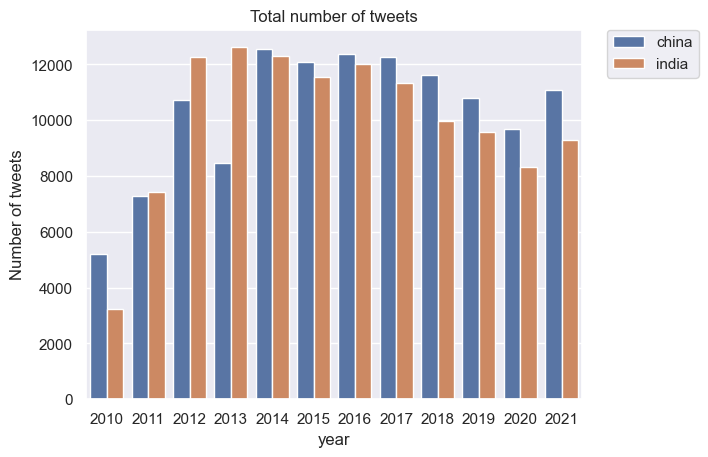

In [265]:
# Brief exploratory data analysis, since we have quite a long period let us see how the number of tweets 
# have evolved for both China and India-related tweets

# Convert the created_at column to DateTime format for plotting
tech_tweets['created_at'] = pd.to_datetime(tech_tweets['created_at'])

# Take the year out of the DateTime and create a column

tech_tweets['year'] = tech_tweets['created_at'].dt.year

# Plot the number of tweets per year with seaborn's countplot
ax = sns.countplot(x='year', data=tech_tweets, hue = 'country')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Total number of tweets')
ax.set_ylabel('Number of tweets')

The graph showcases that the number of tweets increased significantly from 2010 to 2014. Furthermore, China-related tweets have dominated for all but three years (2011, 2012, 2013)

____

2: Resampling

To conduct a thorough analysis of the tweets, it is important to select data that is both recent and relevant to the research question (Chen et al., 1996). To achieve this, the analysis excludes tweets from before 2020 to focus on more recent data (Chen et al., 1996), and randomly draws a sample of 5000 tweets. This approach can help to avoid congestion of the frames and to produce clearer and more relevant results, as the media landscape is constantly changing and tweets from different periods may contain different frames (Tong & Zhang, 2016). By limiting the analysis to a lesser sample size with more recent data, it is possible to create a more focused and representative sample of the tweets that can help to inform the analysis (Tong & Zhang, 2016).

In [266]:
# Removing tweets from before 2020

tech_tweets = tech_tweets[tech_tweets['year'] >= 2020]

In [267]:
# Randomly subsampling the data frame by drawing 5000 tweets

# Setting a seed to maintain the same samples through multiple iterations
seed = 88

# Select 5000 rows at random from the dataframe
tech_tweets = tech_tweets.sample(n=5000, random_state=seed)

In [268]:
# Checking the distribution between China and India-related tech tweets. It is 53/47 which is just all right

tech_tweets.groupby(['country'])['country'].count()

country
china    2695
india    2305
Name: country, dtype: int64

2.1: Preprocessing part two

In [269]:
# Preprocessing part two: Keeping only words of interest and lemmatizing
# Using lemmatization instead of stemming to help preserve the interpretability of the text, as the resulting words are still recognizable and have meaning in the context of the text (Hassan, 2018).

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# Creating a function to keep only verbs, nouns, adjectives, and names, and lemmatize the words
def keep_verbs_nouns_adj_names(text):
    # Parse the text with spacy
    doc = nlp(text)
    
    # List comprehension for words to keep
    words = [token.lemma_ for token in doc if token.pos_ in ['VERB', 'ADJ', 'NOUN', 'PROPN', 'ADV']]
    
    # Join the words back into a single string
    return " ".join(words)

tech_tweets['clean_tweet'] = tech_tweets['clean_tweet'].apply(keep_verbs_nouns_adj_names)

In [270]:
# Subset the data frame into a China frame (china_tweet) and a India frame (india_tweet)

china_tweets = tech_tweets[tech_tweets['country'] == 'china'][['year', 'clean_tweet']]
india_tweets = tech_tweets[tech_tweets['country'] == 'india'][['year', 'clean_tweet']]

_______

K-means

3: K-means clustering: hyperparameter tuning and validation

In [271]:
# Creating TF-IDF to perform k-means clustering using altered code from seminar 2

import warnings

warnings.filterwarnings('ignore')

# Creating the vectorizer object. Using min_df = 10 to ensure words appear at least 10 times in the documents (tweets).
# The value here is to ensure that frames consist of at least 10 tweets to filter out the noise and focus on more significant trends
# Using max_df = 0.4 to remove words that appear in more than 40% of tweets helps to focus on more specific trends and frames rather than general, widely-used terms

vectorizer = TfidfVectorizer(min_df=10, max_df=0.4) 

# Vectorizing Chinas tweets
china_X = vectorizer.fit_transform(china_tweets['clean_tweet'])
china_tf_idf = pd.DataFrame(data = china_X.toarray(), columns = vectorizer.get_feature_names())

print(f'The TF-IDF for China is: {china_tf_idf.shape}')

# Vectorizing Indias tweets
india_X = vectorizer.fit_transform(india_tweets['clean_tweet'])
india_tf_idf = pd.DataFrame(data = india_X.toarray(), columns = vectorizer.get_feature_names())

print(f'The TF-IDF for India is: {india_tf_idf.shape}')

The TF-IDF for China is: (2695, 637)
The TF-IDF for India is: (2305, 536)


In [272]:
# For computability's sake, the code reduces dimensionality by converting the Pandas data frame to a sparse matrix

china_tf_idf_sparse = china_tf_idf.astype(pd.SparseDtype("float", 0))

india_tf_idf_sparse = india_tf_idf.astype(pd.SparseDtype("float", 0))

In [273]:
# Using code from seminar 2 to create unsupervised modelling and find the k-means clusters

# Modifying the code to a function so calling it is easy for both China and India
def find_k(tf_idf): 
    np.random.seed(123)

    # Create a list to store the sum of squared distances for each loop below
    inertia = []

    # Create an object K with the range of clusters. Chosing 1-15 in this as we want more dense frames
    K = range(1, 15)

    # Loop over the values in K
    for k in K:
        # Create a KMeans model with the current number of clusters
        kmeanModel = KMeans(n_clusters=k)

        # Fit the model to the dataset
        kmeanModel.fit(tf_idf)

        # Append the sum of squared distances to the inertia list
        inertia.append(kmeanModel.inertia_)

    # Use the KneeLocator class to find the optimal number of clusters
    
    kn = KneeLocator(K, inertia, curve = 'convex', direction = 'decreasing')
    print(f'The optimal number of clusters is {kn.knee} with a SDD (sum of squared distances) of {kn.knee_y:.2f}')
    
    # Create a plot
    plt.figure(figsize = (10,5))
    plt.title('KneeLocator finding optimal number of clusters')
    plt.xlabel('number of clusters k')
    plt.ylabel('Sum of squared distances')
    plt.plot(K, inertia, 'bx-')
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles= 'dashed')

The optimal number of clusters is 5 with a SDD (sum of squared distances) of 2372.13


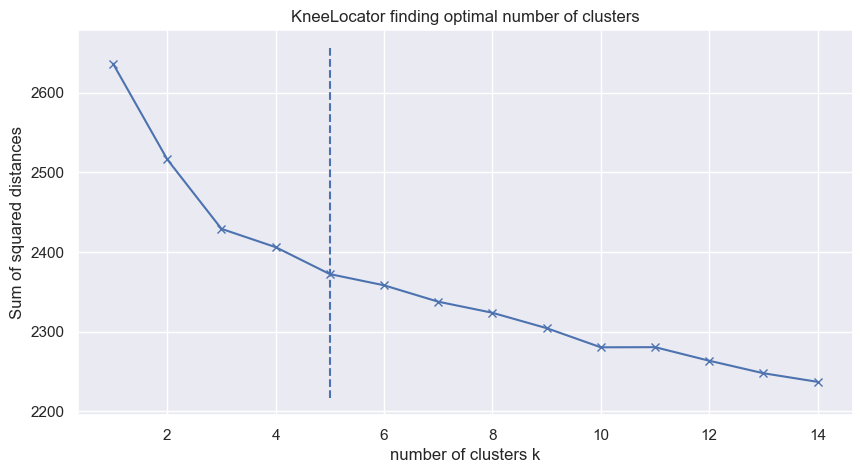

In [274]:
# Finding the optimal number of K's for China TF-IDF

find_k(china_tf_idf_sparse)

# As per the graph below, the optimal number of K's = 5

The optimal number of clusters is 9 with a SDD (sum of squared distances) of 2083.97


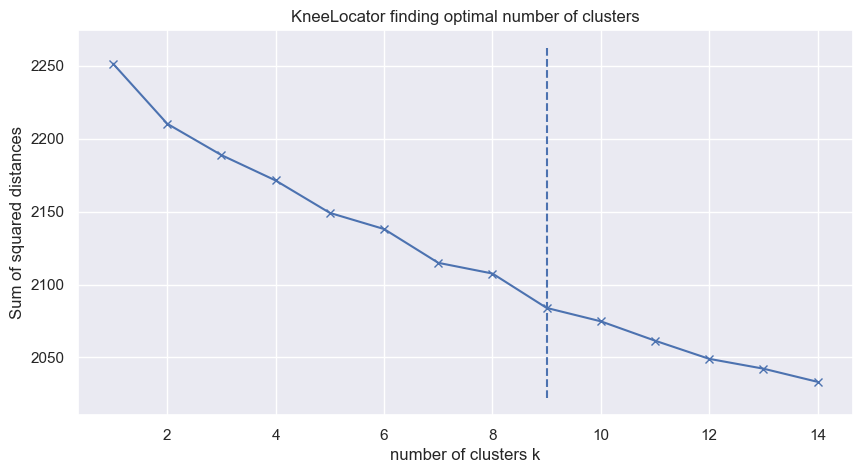

In [275]:
# Finding the optimal number of K's for Indias TF-IDF

find_k(india_tf_idf_sparse)

# As per the graph below, the optimal number of K's = 9

In [276]:
# Altering and combining code from seminar 2 into a function to find the top words for each cluster

def cluster_tweets(tf_idf_matrix, country, vectorizer, num_clusters):
  np.random.seed(123)
  
  # Creating a KMeans model with the specified number of clusters
  kmeanModel = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=3000, random_state=0)

  # Fit the model for the TF-IDF matrix
  mod = kmeanModel.fit_transform(tf_idf_matrix)

  # Use the model to predict the cluster for each tweet
  country['clean_tweet'] = kmeanModel.predict(tf_idf_matrix)

  # Find the top words for each cluster
  order_centroids = kmeanModel.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer.get_feature_names()
  dict = []
  for i in range(num_clusters):
    print("%d" % i, sep='', end=','),
    for ind in order_centroids[i, :15]:
      if ind >= 0 and ind < len(terms):
        print(terms[ind], sep ='', end =',')
    print('')

3.1: K-means clustering: fitting and analysis

In [277]:
cluster_tweets(china_tf_idf_sparse, china_tweets, vectorizer, 5)

0,post,reveal,live,employee,electronic,isro,chapter,make,engineering,
1,facebook,model,identify,huge,httech,house,hospital,horsewhip,home,hold,hogayi,
2,rule,bill,opindia,fund,ecosystem,nation,confirm,go,register,chapter,full,boost,ready,hobli,
3,fintech,think,follow,force,whatsapp,information,httech,house,hospital,horsewhip,hope,home,hold,hobli,hogayi,
4,defence,drericding,important,xiaomi,make,tomorrow,lakh,isro,enough,drdo,artificialintelligence,scale,expect,


The analysis of the k-means clustering results on China-related tech tweets reveals that the clusters represent a wide range of themes, including financial technology, politics, social media, economics, and censorship/defence. 

While the sum of squared distances for the clustering is 2372.12 per the graph output, indicating some error, the reoccurring words and patterns in each cluster offer insight into the media frames surrounding these issues. Two of the most interesting clusters are cluster 3 and cluster 4. Cluster 3, which includes words such as "fintech," "think,", "information", and "force," appears to pertain to entrepreneurship and the massive landscape of Chinese fintech (Bo-eun, 2022). Cluster 4, with words like "defence," "Xiaomi," and "important," seems to relate to global politics and legal issues of censorship in China. Especially with the Xiaomi phone, which has built-in software to censor words such as 'democracy movement' (Klingert, 2021). These two clusters are particularly relevant for this analysis examining media framing of China and tech-related topics.

In [278]:
cluster_tweets(india_tf_idf_sparse, india_tweets, vectorizer, 9)

0,dictate,legal,opindia,comply,profit,policy,private,company,indian,govt,twitter,exclusive,global,give,get,
1,smartphone,apple,iphone,xiaomi,oneplus,screen,make,uwhdaofs,athavale,abhi,horsewhip,identify,soon,read,samsung,
2,technology,make,year,world,company,facebook,large,say,sector,join,work,good,high,help,need,
3,first,state,time,stand,existence,iyervval,argue,speech,citizen,today,free,indian,apple,open,store,
4,talk,technicalguruji,pubg,mobile,launch,iphone,floor,redmi,note,wing,bangalore,simi,embassy,varthur,tower,
5,covid,government,twitter,remove,indian,request,tweet,several,include,vaccine,critical,drericding,critica,discussion,fight,
6,launch,realme,price,oneplus,amreliaruhez,live,series,vivo,redmi,camera,samsung,phone,display,galaxy,hogayi,
7,startup,indian,raii,omkar,technology,industry,meity,company,product,build,unicorn,make,digital,stpiindia,employee,
8,break,jackposobiec,jail,official,national,social,medium,announce,global,full,fund,funding,head,future,gadget,


The second analysis of the k-means clustering results, focusing on India-related tech tweets, also identifies several reoccuring themes, including start-ups, technology, business, covid, and social media. 

The analysis has a better SSD error as compared to the China-part, indicated by a sum of squared distances of 2083.97 so the clusters are more dense than the above China analysis. The analysis also suggests more clusters than it does for China. However, as visible on the graph, there is no significant elbow point on the graph, and 5 clusters could also have been chosen. This indicates that the range of topics are diverse, especially for the India subset of the data. 

For the recurring words and patterns in this analysis, the clusters offer valuable insights into how India are being framed in the tech related media. Two clusters that stands out are cluster 7, which includes words such as "startup," "unicorn," and "digital," and seems to relate to the start-up sector and digital innovation. Cluster 6 also stands out, which includes words like "launch", "vivo," "realme," and "oneplus," and appears to pertain to consumer goods and specific tech brands. These clusters differ from the China-related clusters previously mentioned and create a gap between the recurring patterns associated with China and India, and the resulting frames.

___

4: LDA set-up, with hyperparameter tuning - inspired by code from seminar 2 with additions and adaptions: https://solisservices.sharepoint.com/:u:/r/sites/CriticalDataMiningofMediaCultureINFOMCDMMC/Shared%20Documents/General/Solutions%20and%20Python%20Scripts/INFOMCDMMC_Seminar2_Exercises_Solutions_colab.ipynb?csf=1&web=1&e=5AaFUx

In [279]:
# Reloading the tweet subsets as the code above reshaped the 'clean_tweet' objects

china_tweets = tech_tweets[tech_tweets['country'] == 'china'][['year', 'clean_tweet']]
india_tweets = tech_tweets[tech_tweets['country'] == 'india'][['year', 'clean_tweet']]

The following code creates modular subfunctions to perform various tasks in the topic modeling process. The first subfunction localizes optimal coherence values for a range of clusters. The second subfunction generates wordclouds for the topic modeling. The main function is also defined that utilizes these subfunctions to allow for easy modification and testing of the code, including the validation and optimization of hyperparameters. The use of modular subfunctions helps to make the code more organized and maintainable. 

Sub function 1: Get optimal number of topics

In [280]:
# Create a function to find the optimal number of topics with the max coherence value.
# Using coherence = 'c_v' as it yielded the best fit doing multiple iterations of the analysis

def get_optimal_num_topics(dictionary, corpus, texts, start, limit, step):
    # Create empty lists to store coherence values and model objects
    coherence_values = []
    model_list = []
    
    # Iterate through a range of number of topics from start to limit, in increments of step
    for num_topics in range(start, limit, step):
        # Create an LDA model with the current number of topics
        model = LdaModel(corpus=corpus, num_topics=num_topics)
        # Append the model to the model list
        model_list.append(model)
        # Create a CoherenceModel object using the current model, texts, dictionary, and coherence measure
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # Append the coherence score to the coherence values list
        coherence_values.append(coherencemodel.get_coherence())
    

    # Create a list of x-values for the plot
    x = range(start, limit, step)
    plt.figure(figsize=(10,5))
    plt.bar(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Number of Topics")
    # Add a vertical line at the x-value corresponding to the maximum coherence score
    plt.vlines(x[np.argmax(coherence_values)], plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r')
    plt.show()
    
    # Get the number of topics corresponding to the maximum coherence score
    max_coherence = max(coherence_values)
    num_topics = x[np.argmax(coherence_values)]
    return num_topics, max_coherence

# This function is going to be used as a subfunction in the analysis of topic modelling

Sub function 2: Plot wordclouds for optimal number of topics

In [281]:
# Creating a function to initiate a wordcloud for both analysis
def plot_wordcloud(topics):
    # Create a subplot for each topic
    fig, axs = plt.subplots(1, len(topics), figsize=(20, 10))

    # Set the overall background color of the plot to white
    fig.set_facecolor('white')

    for i, topic in enumerate(topics):
        # Split the topic into a list of words and weights
        words = list(topic[1].split('+'))
        # Create a wordcloud object using the words as the text
        # Set the background color of the wordcloud to white
        wordcloud = WordCloud(width=600, height=400, background_color='white').generate(' '.join(words))
        # Plot the wordcloud on the subplot
        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].axis("off")
        # Set the title of the subplot to the topic number
        axs[i].set_title(f'Topic {topic[0]}')
    # Show the plot
    plt.show()

Main function: Retrieve the LDA topics while using sub function 1 and 2

In [282]:
# Create a main function, which is going retrieve the LDA topics for both China and India and utilize the two prior subfunctions
# Setting id2word filters equal to: no_below = 10 and no_above = 0.4 to ensure internal validity between the k-means clustering and the topic modelling analysis

def get_lda_topics(data, text, start, limit, step):
    # Set the random seed for reproducibility
    np.random.seed(123)
    
    # Tokenize the 'text' column of the data
    data['tokens'] = data[text].apply(word_tokenize)
    # Create a dictionary object using the tokens
    id2word = Dictionary(data['tokens'])
    # Filter out tokens that appear in less than 10 documents or in more than 40% of documents
    id2word.filter_extremes(no_below=10, no_above=0.4)
    # Create a corpus object using the tokens and the dictionary
    corpus = [id2word.doc2bow(doc) for doc in data['tokens']]
    
    # Get the optimal number of topics using the function defined above
    num_topics, max_coherence = get_optimal_num_topics(dictionary=id2word, corpus=corpus, texts=data['tokens'], start=start, limit=limit, step=step)
    # Print the optimal number of topics and the corresponding coherence score
    print(f'The optimal number of topics is {num_topics} with a coherence score of {max_coherence:.3f}.')
    
    # Create an LDA model with the optimal number of topics and the dictionary
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
    # Get the topics from the model
    topics = model.print_topics()
    
    # Plot the wordcloud
    print('\nWordclouds for all topics')
    plot_wordcloud(topics)
    
    # Get the perplexity of the final model
    perplexity = model.log_perplexity(corpus)
    print(f'The perplexity of the final model is {perplexity:.3f}.\n')
    
    # Iterate through the topics and print their top words and weights
    for topic in topics:
        print(f'Topic {topic[0]}:')
        print(f'Top words and weights: {topic[1]}')

The get_lda_topics function is used to determine the optimal hyperparameter settings for Latent Dirichlet Allocation (LDA). The manual parameters in the function, id2word.filter_extremes(no_below=10, no_above=0.4), have been fine-tuned to filter out tokens that appear in fewer than 10 documents or in more than 40% of documents (Gentzkow et al., 2019). This helps to improve the coherence of the resulting topics and reduce noise by ignoring rare words and those that are too common. The parameter no_below ensures that words that appear in fewer than 10 documents are ignored, while no_above filters out words that appear in more than 40% of documents, which helps to reduce overlap between the topics (Gentzkow et al., 2019).

The get_optimal_num_topics function is designed to identify the optimal number of topics for a given dataset using the 'c_v' retrieval method (Tong & Zhang, 2016). This method is well-suited for topic modeling of tweets because it reduces the risk of overfitting and generates more coherent topics (Tong & Zhang, 2016). In comparison to other methods such as the elbow method or the silhouette method, the 'c_v' method has been shown to be more reliable and consistent in determining the optimal number of topics for Latent Dirichlet Allocation (LDA) models (Tong & Zhang, 2016).

________

4.1: LDA analysis with coherence scores, perplexity and wordclouds

***China***

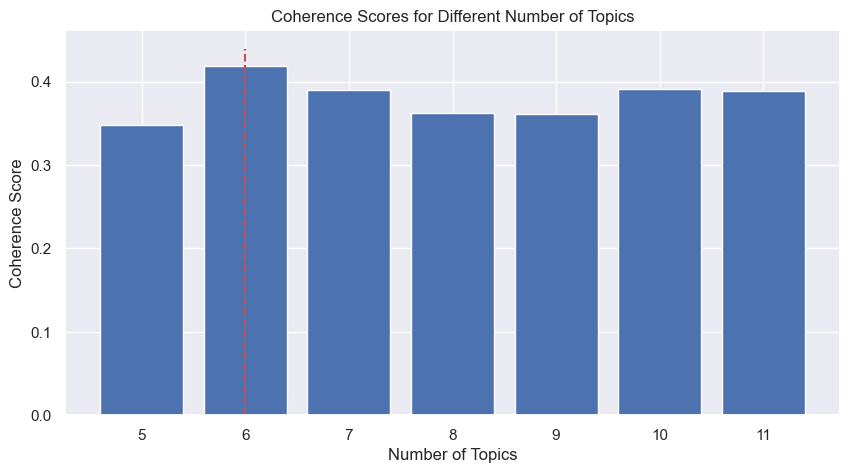

The optimal number of topics is 6 with a coherence score of 0.419.

Wordclouds for all topics


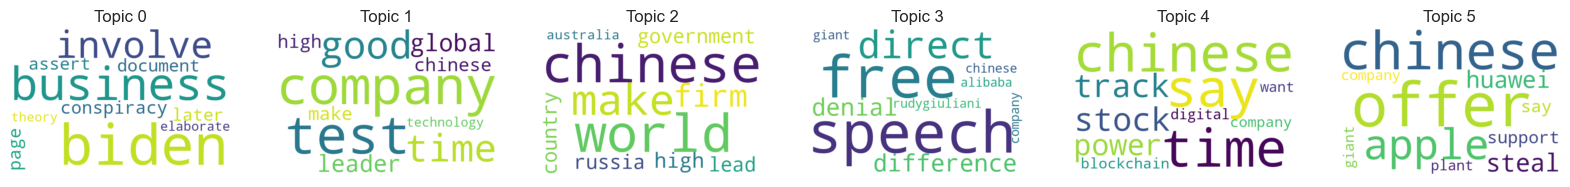

The perplexity of the final model is -6.218.

Topic 0:
Top words and weights: 0.059*"biden" + 0.045*"business" + 0.044*"involve" + 0.040*"conspiracy" + 0.039*"page" + 0.039*"document" + 0.039*"later" + 0.039*"assert" + 0.033*"elaborate" + 0.033*"theory"
Topic 1:
Top words and weights: 0.030*"company" + 0.013*"test" + 0.013*"good" + 0.012*"time" + 0.012*"global" + 0.011*"leader" + 0.010*"chinese" + 0.010*"make" + 0.010*"high" + 0.010*"technology"
Topic 2:
Top words and weights: 0.038*"chinese" + 0.017*"world" + 0.015*"make" + 0.015*"firm" + 0.014*"high" + 0.013*"government" + 0.013*"russia" + 0.011*"country" + 0.010*"lead" + 0.010*"australia"
Topic 3:
Top words and weights: 0.040*"free" + 0.039*"speech" + 0.036*"direct" + 0.036*"denial" + 0.035*"difference" + 0.035*"rudygiuliani" + 0.016*"chinese" + 0.016*"alibaba" + 0.014*"giant" + 0.012*"company"
Topic 4:
Top words and weights: 0.018*"chinese" + 0.014*"say" + 0.013*"time" + 0.013*"stock" + 0.012*"track" + 0.011*"power" + 0.011*"blockc

In [283]:
get_lda_topics(china_tweets, 'clean_tweet', start = 5, limit= 12, step = 1)

The analysis found that the optimal number of topics for the dataset is 6, with a coherence score of 0.419. This moderate score suggests that the identified topics are distinct and coherent, but some overlap or ambiguity may still exist (Onan et al, 2016). What is furthermore interesting is that the difference in coherence scores is not too significant. As evident from the barplot, there are clusterings with better scores, but these are not too far ahead of the slightly lesser compositions. The wordclouds help navigate the size proportions between the words in the different topics. 

The perplexity of the final model is -6.218, indicating a very good fit to the data (Onan et al, 2016). The model identified six topics in the dataset, each characterized by its own set of top words and weights. The media frames for each topic are as follows:

    -Topic 0: Business, conspiracy theories
    -Topic 1: Companies, global leadership, technology
    -Topic 2: Chinese firms, global relations, government
    -Topic 3: Free speech, denial, difference
    -Topic 4: Chinese companies, digital innovation, blockchain
    -Topic 5: Chinese companies, trade relations, theft accusations

These results suggest that the media frames present in the dataset vary in their connotation and discourse. Topics 0, 3, and 5 contain negative framing elements, such as conspiracy theories, theft accusations, and denial of free speech, which could imply that some Twitter users are using these frames to discredit or attack China and Chinese-related topics in a tech context. However, other frames present a more positive context. For example, topic 4, suggests that the context of Chinese firms is digital innovation within blockchain technology. 

_________

***India***

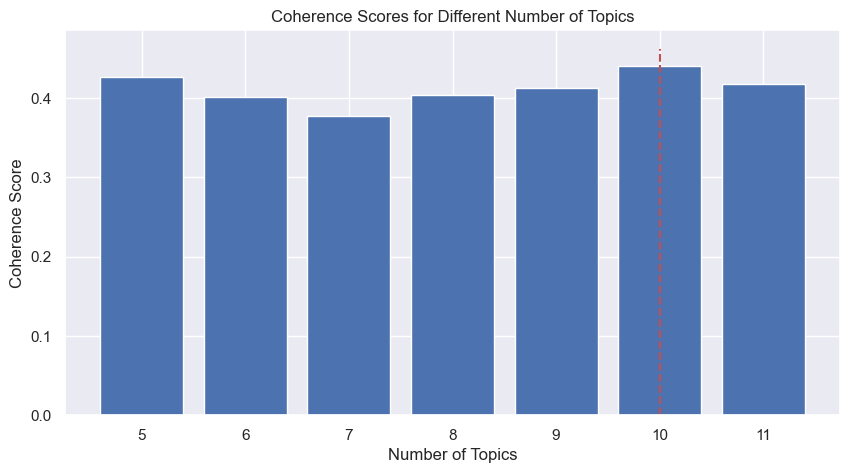

The optimal number of topics is 10 with a coherence score of 0.440.

Wordclouds for all topics


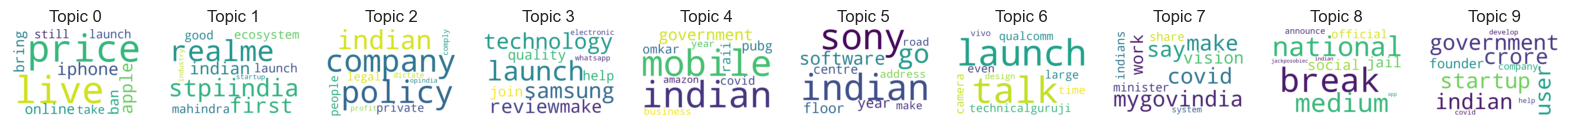

The perplexity of the final model is -6.532.

Topic 0:
Top words and weights: 0.029*"price" + 0.026*"live" + 0.025*"iphone" + 0.018*"apple" + 0.017*"online" + 0.016*"bring" + 0.016*"ban" + 0.015*"launch" + 0.014*"still" + 0.014*"take"
Topic 1:
Top words and weights: 0.030*"realme" + 0.026*"stpiindia" + 0.025*"first" + 0.021*"indian" + 0.020*"ecosystem" + 0.020*"launch" + 0.016*"mahindra" + 0.016*"good" + 0.016*"startup" + 0.014*"industry"
Topic 2:
Top words and weights: 0.044*"company" + 0.035*"policy" + 0.026*"indian" + 0.021*"private" + 0.021*"people" + 0.019*"legal" + 0.019*"dictate" + 0.018*"comply" + 0.018*"profit" + 0.018*"opindia"
Topic 3:
Top words and weights: 0.032*"launch" + 0.023*"technology" + 0.019*"samsung" + 0.015*"review" + 0.014*"make" + 0.014*"quality" + 0.013*"join" + 0.013*"help" + 0.013*"electronic" + 0.012*"whatsapp"
Topic 4:
Top words and weights: 0.039*"mobile" + 0.032*"indian" + 0.026*"government" + 0.024*"pubg" + 0.020*"raii" + 0.020*"omkar" + 0.018*"covid" +

In [284]:
get_lda_topics(india_tweets, 'clean_tweet', start = 5, limit= 12, step = 1)

The analysis found the best fit for LDA modelling with 10 clusters. The perplexity of the final model for India-related tech tweets is -6.532, also indicating a very good fit to the data similar to the analysis above (Onan et al, 2016). The coherence score of 0.440 is slightly better than the China subset and exerts the same positive benefits while ambiguity and overlap may still exist (Onan et al, 2016). 

Overall, these results suggest an equally diverse range of media frames related to the tech industry in India, including such frames as start-ups, international competition, eco-systems, software, government and legal issues, and covid. The model identified 10 topics in the dataset, each characterized by its own set of top words and weights. The media frames for each topic are as follows: 

    -Topic 0: international companies, prices, launches
    -Topic 1: Indian tech start-ups, ecosystem, industry
    -Topic 2: Indian companies, policies, legal issues
    -Topic 3: Tech launches, reviews, electronic devices
    -Topic 4: Mobile phones, Indian government, business
    -Topic 5: Indian tech industry, Sony, software
    -Topic 6: Launches, technical topics, cameras
    -Topic 7: Covid-19, Indian government, vision
    -Topic 8: National issues, social media, official announcements
    -Topic 9: Indian government, tech start-ups, funding

These results suggest that the media frames present in the dataset also vary in their connotation and discourse. However, as compared to the analysis above, no frames have as negative contexts as Topics 0, 3, and 5 in the China analysis. The overall more moderate and positive discourse, for example, topic 2 about Indian tech start-ups and that industry point to some Twitter users using frames highlighting and endorsing India and India-related topics in a tech context. However, although the frames present have more positive context, some are still ambitious. For example, topic 8, has a frame of national issues such as words like "jail" and "break. This implies the analysis is not one-sided, and that the conclusions drawn from this analysis should be substantiated further. 

______

## Question 2.3

**Discuss your results critically: what can we learn about the dicussion of technologies in the Indian and Chinese cases? What are the limitations of your chosen methods but also the data?**

5: Summary

The chosen methodology and framework were used to analyze and compare the framing of India and China in tech-related tweets. The k-means clustering identified recurring patterns of words for both countries, such as fintech, social media, censorship, and defense for China, and start-ups, business, and covid for India. This operationalization of frames as recurring patterns of words revealed latent differences in the framing of China and India in tech-related tweets (Entman, 1993) & (Heidenreich et al., 2019).

These differences were substantiated by the LDA analysis, which found more negative frames for China-related tweets, such as conspiracy theories and free speech denial (Chesbrough, 2012), while overall the LDA analysis found more neutral and positive frames for India-related tweets, such as the Indian tech start-up frame, which was highlighting and endorsing (Zhang & Chib, 2014). These results bring forward some important discussions on methods and data.

It's important to note that there are some limitations to the chosen methods and data that should be considered before concluding the negative framing of China. One limitation is that the analysis is based on tweets, which may not be representative of all media coverage of technology in these countries, and especially in China (Zhang & Chib, 2014). Twitter is a US-created and dominated medium, and during this period, a lot of criticism came from the US President at the time, Donald Trump, towards China (Larres, 2020). Furthermore, the analysis is restricted to tweets from 2020 or later, which means it may not fully capture the media framing of technology in these countries over a longer period. To improve external validity, the study could include more Asian-created/dominated mediums and forums, such as Weibo, Baidu Tieba, and WeChat.

Another limitation is that k-means clustering is a relatively simple algorithm that does not take into account the context or meaning of the words and phrases in the text (Shukla & Naganna, 2014). As a result, this method may not provide as nuanced or comprehensive a view of the text as other methods, such as sentiment analysis (Medhat & Korashy, 2014) or discourse analysis (Van Dijk, 2015). To improve internal validity, the study could consider using these other methods, which can provide a more detailed and sophisticated analysis of the text and help to understand the overall framing of the tweets more effectively.


# Task Three (20 points)

## Question 3.1

**Identify the top 15 NOUNS most strongly associated with “clickbait”. Choose a method for pre-processing the texts prior to analysis that allows you to do this. Discuss and explain why these words are indicative for the “clickbait” category (or why not). Does it make sense to focus on NOUNS only?**

In [285]:
# Import the dataset (.csv) for the question

path = r'/Users/albertcortbanke/Desktop/Q3_clickbait.csv'

clickbait = pd.read_csv(path,index_col=0)

# Creating a copy for later on
clickbait_copy = clickbait.copy()

# 1) To begin with a quick exploratory analysis of the dataset is in order to check the state of the data (missing values, wrong format, non-unique values etc.) 

# Inspect the head of the dataset to see whether the dataset has been loaded correctly

clickbait.head()

# The data looks good yet again

,title,label
0,15 Highly Important Questi...,1
1,250 Nuns Just Cycled All T...,1
2,"Australian comedians ""coul...",0
3,Lycos launches screensaver...,0
4,Fußball-Bundesliga 2008–09...,0


In [286]:
# Quick inspection of the data frame's cardinality, types, and completion

clickbait.info()

# Data frame is complete and the columns have the correct data types - let's move on to preprocessing 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31986 entries, 0 to 31985
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   31986 non-null  object
 1   label   31986 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 749.7+ KB


1. Preprocessing (with and without lemmatization)

Chosing to conduct the analysis with two different variations of preprocessing (with and w/o lemmatization) allows the study to compare pros and cons of the varations. The hypothesis is that lemmitization will help reduce the total number of nouns and aid the study to find more distinct nouns (Balakrishnan & Lloyd-Yemoh, 2014).

    Balakrishnan, V., & Lloyd-Yemoh, E. (2014). Stemming and lemmatization: A comparison of retrieval performances.

In [287]:
# Two preprocess steps here. One without lemmetization and one without. Results are compared and contrasted

# Similar preprocessing as in Q1, as the two text columns holds similarities

# Without lemmetization:

clean_text = lambda text: re.sub(r'[^\w\s]','',text.lower().strip())

clickbait['clean_title'] = clickbait['title'].apply(clean_text)

# Create a list of stopwords again since the last one was altered
stopwords = nltk.corpus.stopwords.words()

# Adding custom stopwords after trial and error of conducting the below analysis multiple times
stopwords.extend(['youre', 'heres', 'whats'])

def get_nouns(text):
    # Use NLTK to tokenize and tag the words in the text
    tagged_words = nltk.pos_tag(nltk.word_tokenize(text))

    # Return only the words that are tagged as nouns and not in the list of stopwords
    # For this assignment nouns are assumed to be singular, plural as well as proper
    return [word for word, pos in tagged_words if pos in ['NN', 'NNS', 'NNP', 'NNPS'] and word not in stopwords]

# Apply the function and create the nouns column using the apply() method
clickbait['nouns'] = clickbait['clean_title'].apply(get_nouns)


In [288]:
# With lemmetization:

stopwords = nltk.corpus.stopwords.words()

def get_nouns_lemm(text):
    # Use NLTK to tokenize and tag the words in the text
    tagged_words = nltk.pos_tag(nltk.word_tokenize(text))

    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Return only the lemmatized words that are tagged as nouns and not in the list of stopwords
    # For this assignment nouns are assumed to be singular, plural as well as proper
    return [lemmatizer.lemmatize(word) for word, pos in tagged_words if pos in ['NN', 'NNS', 'NNP', 'NNPS'] and word not in stopwords]

# Apply the function and create the nouns column using the apply() method
clickbait['nouns_lem'] = clickbait['clean_title'].apply(get_nouns_lemm)

In [289]:
# Dropping all columns except for label and nouns and nouns_lem 

clickbait = clickbait.drop(columns = ['title', 'clean_title'])

clickbait # data frame looks good

,label,nouns,nouns_lem
0,1,"[questions, adulthood, mic...","[question, adulthood, mich..."
1,1,"[nuns, kathmandu, delhi]","[nun, kathmandu, delhi]"
2,0,"[comedians, apec, prank]","[comedian, apec, prank]"
3,0,"[lycos, spammers, bills]","[lycos, spammer, bill]"
4,0,"[butt, signs, munich]","[butt, sign, munich]"
...,...,...,...
31981,0,"[online, friends, shop]","[online, friend, shop]"
31982,1,"[zodiac, sign]","[zodiac, sign]"
31983,1,[reaction],[reaction]
31984,0,"[saturns, moon, hosts, lak...","[saturn, moon, host, lake,..."


2. Analysis

For the clickbait analysis, log-likelihood with chi-square tests and p-values are used to identify nouns that are most strongly associated with "clickbait" (Lancaster & Seneta, 2005). By using chi-square tests and p-values, the analysis is able to determine which nouns are most likely to be used in clickbait headlines and identify patterns and trends in the data (Chawda et al., 2019). This information can then be used to develop strategies for identifying and combating clickbait, as well as for understanding the factors that contribute to the success of clickbait headlines.

In [290]:
# Analysis without lemmetization 

# Create a new column containing only the nouns as a single string
clickbait['noun_string'] = clickbait['nouns'].apply(lambda x: ' '.join(x))

# Use TfidfVectorizer to calculate the TF-IDF scores for each noun
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(clickbait['noun_string'])

# Use chi2 and p-values to determine the nouns that are most strongly associated with "clickbait"
chi2_scores, p_values = chi2(X, clickbait['label'])

# Sort the nouns by their chi2 scores and select the top 15
top_nouns = sorted(zip(tfidf.get_feature_names(), chi2_scores), key=lambda x: x[1], reverse=True)[:15]

# Print the top nouns and their chi2 scores
print(top_nouns)

# The top words are 'things', 'times' and 'tweets'. Below is code looking at some of the titles containing the word things

[('things', 490.21654558643456), ('times', 176.02566539491758), ('tweets', 141.56005325629445), ('zodiac', 133.96760790174199), ('pictures', 131.1918644031977), ('life', 125.57649104281977), ('ways', 121.15155631741162), ('character', 119.66466329624646), ('photos', 108.59959086820112), ('reasons', 101.82476410213818), ('president', 99.63682430166804), ('movie', 95.93434593678407), ('sign', 95.29937788988411), ('questions', 91.19562841167765), ('gifts', 86.2432379781518)]


In [291]:
pd.set_option('max_colwidth', 500)

clickbait_copy[(clickbait_copy['label'] == 1) & (clickbait_copy['title'].str.contains('Things'))]


,title,label
24,10 Life-Changing Things To Try In November,1
60,37 Things The Kardashians Have 100% Actually Said,1
114,"18 Things You Didn't Know About ""While You Were Sleeping""",1
117,"17 Things ""The Sandlot"" Actually Taught You About Life",1
147,"24 Things You 100% Did Not Notice In ""Jurassic World""",1
...,...,...
31912,18 Things You Need To Know About Drinking Coffee,1
31932,21 Things Scotland Has That The Rest Of The World Needs To Get In 2016,1
31951,19 Things That Happen When You're Single AF During Christmas,1
31969,21 Things Everyone Who Does BodyPump Will Understand,1


Looking at the output from the code with titles that contain clickbait, "things" is representative of click-bait title nouns. '10 Life-Changing Things To Try In November' sounds very click-baity - (and interesting. What life-changing things could this be that November holds?). Furthermore, '18 Things You Need to Know About Drinking Coffee' is another favorite. The results from the chi-square tests looks good, as the identification of "things" amongst other nouns. 

In [292]:
# Analysis with lemmetization 

# Create a new column containing only the nouns as a single string
clickbait['noun_string'] = clickbait['nouns_lem'].apply(lambda x: ' '.join(x))

# Use TfidfVectorizer to calculate the TF-IDF scores for each noun
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(clickbait['noun_string'])

# Use chi2 to determine the nouns that are most strongly associated with "clickbait"
chi2_scores, p_values = chi2(X, clickbait['label'])

# Sort the nouns by their chi2 scores and select the top 15
top_nouns = sorted(zip(tfidf.get_feature_names(), chi2_scores), key=lambda x: x[1], reverse=True)[:15]

# Print the top nouns and their chi2 scores
print(top_nouns)

# The top words are 'thing', 'time' and 'character'. Below is code looking at some of the titles containing the word character

[('thing', 496.1118149699345), ('time', 230.19520578715748), ('character', 171.12262420623887), ('movie', 158.11027550167816), ('tweet', 154.79752977053334), ('picture', 139.37113211102474), ('zodiac', 138.35268279965925), ('photo', 133.62890051764353), ('youre', 129.4722267758679), ('question', 127.00911026627494), ('way', 123.14124391008652), ('here', 123.04236367643536), ('life', 119.62845744414088), ('reason', 110.85904720534353), ('celebrity', 110.20092256814462)]


In [293]:
clickbait_copy[(clickbait_copy['label'] == 1) & (clickbait_copy['title'].str.contains('Character'))]

,title,label
159,"Can You Match The ""Gilmore Girls"" Season 1 Character To The Quote",1
244,This One Makeup Question Will Determine Your Dominant Character Trait,1
289,"Can You Spot The Real ""Star Wars"" Character From The Fake",1
397,"Which ""Bridesmaids"" Character Should Be Your Maid Of Honor",1
408,"We Know Your Favorite Celebrity Based On Your Favorite ""Agents Of S.H.I.E.L.D."" Character",1
...,...,...
31411,Which Perpetually Miserable Disney Character Are You Really,1
31510,"Do You Remember ""Friends"" Characters' Middle Names",1
31571,"The Zodiac Signs As ""High School Musical"" Characters",1
31702,"12 Undeniable Reasons Denise Hemphill Is The Best Character On ""Scream Queens""",1


The analysis with lemmatization has "character" much higher up in the top nouns list. Without lemmatization character(s) is a position 8, and with it is a position 3. The reason is arguably also the differentiation, where lemmatization has converted characters into character. Meanwhile the former preprocessing did not do this, and the results reflect this difference. 

Looking at the titles with clickbait containing the word "character" much of it looks like BuzzFeed clickbait like: 'Which "Bridesmaids" Character Should Be Your Maid Of Honor'. Another one is very intriguing as well: 'The Zodiac Signs As "High School Musical" Characters'. 

**Answer to Q3.1**

To compare and contrast the above two analyses, the preferred choice of preprocessing is including lemmatization. The reason for this choice is the more compact and unique list of words. By removing duality between words such as 'character' and 'characters' the chi-square analysis is more dense and yields better (and higher) statistical results and certainty. 

There are several reasons why certain words, especially nouns, might be indicative of the "clickbait" category (Zuhroh & Rakhmawati, 2020). First, clickbait headlines often use vague or sensational language to grab the reader's attention and entice them to click on the article (Zuhroh & Rakhmawati, 2020). Nouns such as "things," "character," and "time" are often used in this way, as they can be interpreted in a variety of ways and can be used to pique the reader's curiosity (Zuhroh & Rakhmawati, 2020).

Second, clickbait headlines often use emotional language or appeal to the reader's sense of urgency to get them to click on the article (Indurthi et al., 2020). Nouns such as "reasons" "questions" may be used to create a sense of mystery or excitement (Indurthi et al., 2020). 

Overall, focusing on nouns in the analysis of clickbait headlines makes sense because they are often the most important and most attention-grabbing words in the headline (Indurthi et al., 2020). By analyzing the frequency and use of nouns in clickbait headlines, it is possible to get a better understanding of the tactics and techniques that are being used to entice readers to click on the article (Indurthi et al., 2020). One could also include modal verbs like "must" to strengthen the classification of clickbait titles, as these verbs call for action and often lurk in clickbait titles.

## Question 3.2

**What kind of topics are associated with the “clickbait” and “non-clickbait” titles respectively? Compare the topic types and topic distributions between the two categories.**

In [294]:
# Creating a no_clickbait subset of the data frame
no_clickbait = clickbait[clickbait['label'] == 0]

# Making sure it only contains non-clickbait data and the correct dimensionality
no_clickbait.groupby(['label']).count()

# Looks good! Only label 0 and with half of the original data frame

,nouns,nouns_lem,noun_string
label,,,
0,16000,16000,16000


1. Parameter tuning and analysis

    To improve the coherence between topics, the analysis will re-use the functions created in Question 2 and adjust the hyperparameters to fit the new data frame. The hyperparameters are tuned to maximize coherence and minimize ambiguity in the analysis. This increases the comparison the analysis makes with higher validity (Yun et al., 2022). If the hyperparameters were only optimized for a single topic, it could be possible to tune them to maximize the number of topics, but these topics could potentially be dissociated through linguistic analysis techniques such as discourse analysis(Yun et al., 2022). That methodology would fit better for a singular analysis of (no) clickbait titles.

**Topics associated with clickbait titles**

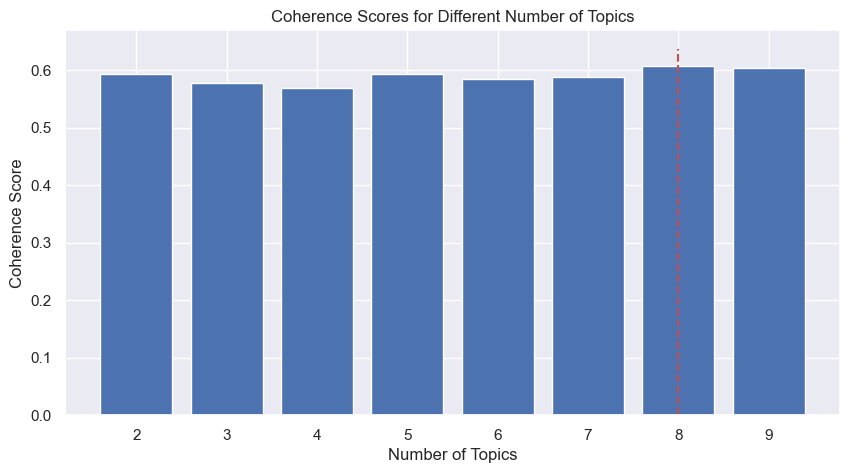

The optimal number of topics is 8 with a coherence score of 0.607.

Wordclouds for all topics


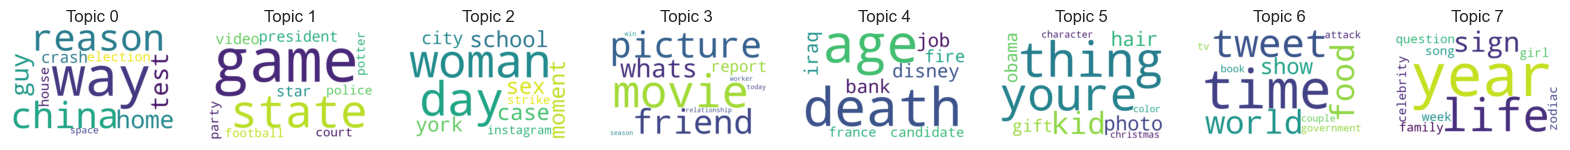

The perplexity of the final model is -7.441.

Topic 0:
Top words and weights: 0.032*"way" + 0.029*"reason" + 0.026*"china" + 0.022*"home" + 0.020*"test" + 0.018*"guy" + 0.017*"crash" + 0.016*"election" + 0.015*"house" + 0.015*"space"
Topic 1:
Top words and weights: 0.034*"game" + 0.029*"state" + 0.028*"president" + 0.025*"star" + 0.023*"video" + 0.020*"police" + 0.018*"party" + 0.018*"football" + 0.015*"court" + 0.014*"potter"
Topic 2:
Top words and weights: 0.043*"woman" + 0.031*"day" + 0.024*"school" + 0.018*"sex" + 0.018*"moment" + 0.017*"case" + 0.017*"york" + 0.014*"city" + 0.013*"instagram" + 0.013*"strike"
Topic 3:
Top words and weights: 0.042*"movie" + 0.038*"picture" + 0.025*"friend" + 0.020*"whats" + 0.019*"report" + 0.014*"relationship" + 0.014*"win" + 0.014*"season" + 0.012*"worker" + 0.011*"today"
Topic 4:
Top words and weights: 0.031*"here" + 0.024*"age" + 0.023*"death" + 0.018*"disney" + 0.017*"job" + 0.016*"bank" + 0.016*"iraq" + 0.014*"fire" + 0.014*"candidate" + 0.013

In [295]:
# The get_lda_topics function is utilized again since it provides the best method to retrieve topics and their distributions
# The hyperparameters are finetuned manually and automatically with the get_optimal_num_topics which uses the 'c_v' retrieval method for the optimal number of topics (clusters)

# Altering the hyperparameters to start = 2, limit = 10 and step = 1 for comparatability

get_lda_topics(clickbait, 'noun_string', start = 2, limit= 10, step = 1)

**Analysis of clickbait titles**

The results of the analysis show that the LDA model is effective in finding coherent and easily distinguishable topics. The coherence score for the optimal model with 8 topics is 0.607, indicating that the topics are well-defined. In addition, the perplexity score of -7.441 suggests that the model fits the data well.

Examining the word clouds and LDA results, one can see that the topics identified are representative of the clickbait titles. For example, topic 3 is related to entertainment and relationships, as indicated by words such as "movie," "picture," "friend," and "relationship." The weights for "movie" and "picture" are particularly high at 0.042 and 0.038, respectively.

Topic 7 is also noteworthy, as it encompasses astrology, celebrities, and family life, with words such as "year," "life," "zodiac," and "celebrity." The distributions of these words are similar to those in topic 3, with weights of 0.046 for "year," 0.040 for "life," and 0.039 for "sign."

In the word clouds, certain words stand out as being particularly frequent in the clickbait titles. For example, "woman" is significant in topic 2, "death" in topic 4, and "thing" in topic 5.

**Topics associated with no_clickbait titles**

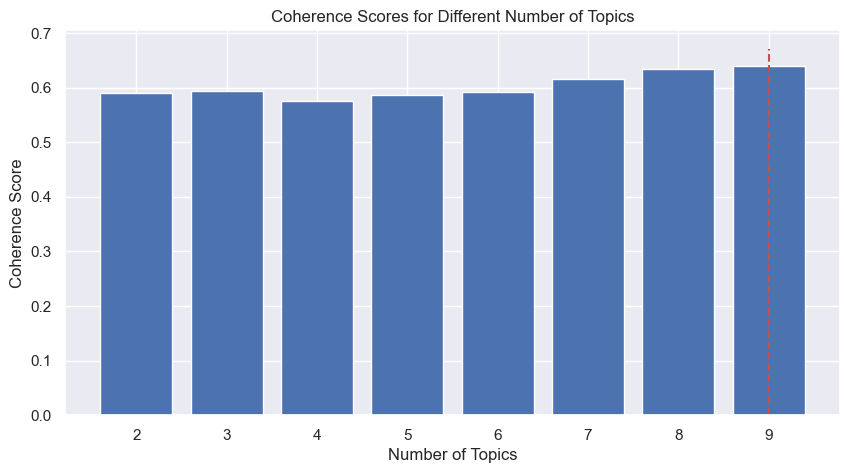

The optimal number of topics is 9 with a coherence score of 0.639.

Wordclouds for all topics


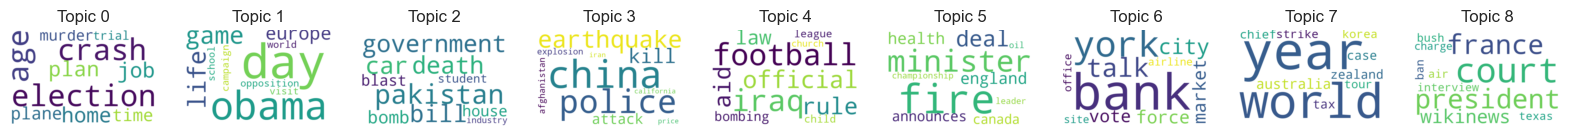

The perplexity of the final model is -7.239.

Topic 0:
Top words and weights: 0.040*"election" + 0.040*"crash" + 0.030*"age" + 0.027*"plan" + 0.023*"job" + 0.023*"home" + 0.019*"plane" + 0.018*"time" + 0.015*"murder" + 0.015*"trial"
Topic 1:
Top words and weights: 0.038*"day" + 0.035*"obama" + 0.022*"game" + 0.018*"life" + 0.017*"europe" + 0.015*"opposition" + 0.014*"campaign" + 0.014*"world" + 0.014*"visit" + 0.013*"school"
Topic 2:
Top words and weights: 0.029*"pakistan" + 0.027*"government" + 0.022*"death" + 0.021*"car" + 0.020*"bill" + 0.018*"bomb" + 0.017*"house" + 0.016*"blast" + 0.014*"student" + 0.013*"industry"
Topic 3:
Top words and weights: 0.043*"china" + 0.033*"police" + 0.026*"earthquake" + 0.022*"kill" + 0.022*"attack" + 0.021*"explosion" + 0.018*"afghanistan" + 0.015*"california" + 0.015*"iran" + 0.015*"price"
Topic 4:
Top words and weights: 0.032*"football" + 0.026*"iraq" + 0.024*"official" + 0.023*"rule" + 0.020*"aid" + 0.017*"law" + 0.017*"bombing" + 0.016*"league" +

In [296]:
# Altering the hyperparameters to start = 2, limit = 10 and step = 1

get_lda_topics(no_clickbait, 'noun_string', start = 2, limit= 10, step = 1)

**Analysis of no_clickbait titles**

The results of the analysis show that the LDA model is effective in finding coherent and easily distinguishable topics. The coherence score for the optimal model with 9 topics is 0.639, sligthly better than the clickbait analysis, indicating that the topics are coherent as well. Furthermore, the perplexity score of -7.239 suggests that the model fits the data well.

Examining the word clouds and LDA results, one can see that the topics identified are representative of the no_clickbait titles. For example, topic 6 is related to finance and economy, as indicated by words such as "bank" (new) "york" "market" and "airline" The weights for "bank" and "york" are the highest for this topic at 0.037 and 0.026, respectively.

Topic 3 is also noteworthy, as it encompasses international news, with words such as "china" "police" "earthquake" and "explosion." The distributions of these words are similar to those in topic 3, with weights of 0.043 for "china" 0.033 for "police" and 0.026 for "earthquake". The coherence here maps the incident with geographical locations to create titles such as 'Earthquake in China'.

In the word clouds, certain words stand out as being particularly frequent in the no_clickbait titles. For example, "year" is significant in topic 7, "obama" in topic 1, and "police" in topic 3.

## Question 3.3

**Explain any differences that you see. Does the results yield any insightful results? Also reflect on the analytical process (pros vs. cons).**

Several differences can be seen between the two groups of titles, as described in the above analysis of the LDA results and its inherent topics and distributions for both clickbait and no_clickbait titles. The no_clickbait titles tend to be more serious and focused on national and international news events, while the clickbait titles are more lighthearted and cover more family-friendly topics (Garcia et al, 2022). The topic distribution also reveals that the clickbait titles have higher weights for words related to entertainment and relationships, while the no_clickbait titles have higher weights for words related to finance, economy, and international news (Garcia et al, 2022).

In terms of the analytical process, one possible pro of using topic modelling (LDA) to find the topic and distribution of titles is that it allows for the automatic identification of patterns and trends in large amounts of text data such the clickbait data (Scacco & Muddiman, 2016). This is useful for quickly summarizing and organizing the content of a large number of titles. However, one potential con is that the results of topic modelling are not always interpretable by humans, and additional analysis may be required to fully understand the implications of the results (Scacco & Muddiman, 2016). This con was mitigated, however, by creating code which visualized wordclouds and highlighted the top words for each topic as well as their weights for said topics.

In media studies, computational methods such as topic modelling can be useful for identifying patterns and trends in media content (Scacco & Muddiman, 2016). However, it is important to be aware of the limitations of these methods, as they may not always accurately capture the full complexity and nuance of media texts(Scacco & Muddiman, 2016). For example, topic modelling may not be able to account for the tone, style, or context of media texts, which can all be important factors in understanding their meaning and significance. While topic modelling may not be suitable for analyzing longer media texts, it can be an effective tool for analyzing titles, which are relatively short strings of text (Scacco & Muddiman, 2016).

Other models for identifying the topics and distribution of titles include Latent Semantic Analysis (LSA) and Latent Semantic Indexing (LSI) (Dumais, 2004). LSA can be sensitive to the size and quality of the dataset, while LSI may be less accurate in identifying subtle relationships and sensitive to predefined categories (Dumais, 2004).

_________

# Task Four (30 points)

## Question 4.1

To answer question 4.1, the following methodology is utilized to classify and identify the pop songs: 

1. Cleaning the data with preprocessing (including lemmatization as per the advantages seen in question 3 which included reducing dimensionality for the vectorization)
2. Creating training and test data for the models
3. Chosing and tuning the models of choice, SVM, Random Forest and Logistic Regression, and optimizing gridsearch for performance. The section proposes arguments for choosing these models and their tuning. 
4. Analysing the results and justifying the choices taken to arrive at the model outcome

The question assumes that the analysis should only use the 'lyrics' column as input variable for predictions.

In [297]:
# Import the dataset (.csv) for the question

path = r'/Users/albertcortbanke/Desktop/Q4_english_cleaned_lyrics.csv'

songs = pd.read_csv(path)

# 1) To begin with a quick exploratory analysis of the dataset is in order to check the state of the data (missing values, wrong format, non-unique values etc.) 

# Inspect the head of the dataset to see whether the dataset has been loaded correctly

songs.head()

# The data looks good

,Unnamed: 0,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut right to the chase Some women were made but me myself I like to think that I was created for a special purpose You know what's more special than you You feel me It's on baby let's get lost You don't need to call into work cause you're the boss For real want you to show me how you feel I consider myself lucky that's a big deal Why Well you got the key to my heart But you ain't gonna need it I'd rather you open up my body And show me secrets you did...
1,5,all-i-could-do-was-cry,2008,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir singing I saw my love Walk down The aisle On her finger He placed a ring Oooh oh I saw them Holding hands She was Standing there Wwith my man I heard Them promise Til death do Us part Each word Was a pain In my heart All I could do All I could do Was cry All I could do Was cry I was Losing the man That I love And all I could do Was cry And now The wedding Is over The rice rice Has been Thrown over Their heads For them life Has just begun But mine ...
2,6,once-in-a-lifetime,2008,beyonce-knowles,Pop,This is just another day that I would spend Waitin for the right one Staring at the night and wishin I could be the one To feel the warm sun You're a dream but I'm wide awake I'm in Heaven for heaven sakes So get ready get ready I'm ready now get ready I could never need you more than now You were worth waiting for You the one that I adore Hold on to me tight For once in my life You were worth waiting for You the one that I adore This kind of love you'll only find Once in a lifetime once in ...
3,9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,N n now honey You better sit down and look around 'Cause you must've bumped yo head And I love you enough to talk some sense back into you baby I'd hate to see you come home Me the kids and the dog is gone Check my credentials I give you everything you want everything you need Even your friends say I'm a good woman All I need to know is why Why don't you love me Tell me baby why don't you love me When I make me so damn easy to love And why don't you need me Tell me baby why don't you need me...
4,16,poison,2009,beyonce-knowles,Pop,You're bad for me I clearly get it I don't see how something good could come from loving you The death of me must be your mission Cause with every hug and kiss you're snatching every bit of strength That I'm gon need to fight off the inevitable And it's a heart breaking situation I'm up in but I can't control You're just like poison Slowly moving through my system Breaking all of my defenses with time You're just like poison and I just don't get it How can something so deadly feel so right I...


In [298]:
# Quick inspection of the data frame's cardinality, types, and completion

songs.info()

# Data frame is complete and the columns have the correct data types, especially the lyrics as a text object, - let us remove the unwanted columns such as 'Unnamed: 0', 'song', 'year' and 'artist'
# As the metric of interest is 'lyrics'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160856 entries, 0 to 160855
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  160856 non-null  int64 
 1   song        160856 non-null  object
 2   year        160856 non-null  int64 
 3   artist      160856 non-null  object
 4   genre       160856 non-null  object
 5   lyrics      160856 non-null  object
dtypes: int64(2), object(4)
memory usage: 7.4+ MB


In [299]:
# Dropping all columns except for label and nouns and nouns_lem 

songs = songs.drop(columns = ['Unnamed: 0', 'song', 'year', 'artist'])

songs # data frame looks good

,genre,lyrics
0,Pop,Oh baby how you doing You know I'm gonna cut right to the chase Some women were made but me myself I like to think that I was created for a special purpose You know what's more special than you You feel me It's on baby let's get lost You don't need to call into work cause you're the boss For real want you to show me how you feel I consider myself lucky that's a big deal Why Well you got the key to my heart But you ain't gonna need it I'd rather you open up my body And show me secrets you did...
1,Pop,I heard Church bells ringing I heard A choir singing I saw my love Walk down The aisle On her finger He placed a ring Oooh oh I saw them Holding hands She was Standing there Wwith my man I heard Them promise Til death do Us part Each word Was a pain In my heart All I could do All I could do Was cry All I could do Was cry I was Losing the man That I love And all I could do Was cry And now The wedding Is over The rice rice Has been Thrown over Their heads For them life Has just begun But mine ...
2,Pop,This is just another day that I would spend Waitin for the right one Staring at the night and wishin I could be the one To feel the warm sun You're a dream but I'm wide awake I'm in Heaven for heaven sakes So get ready get ready I'm ready now get ready I could never need you more than now You were worth waiting for You the one that I adore Hold on to me tight For once in my life You were worth waiting for You the one that I adore This kind of love you'll only find Once in a lifetime once in ...
3,Pop,N n now honey You better sit down and look around 'Cause you must've bumped yo head And I love you enough to talk some sense back into you baby I'd hate to see you come home Me the kids and the dog is gone Check my credentials I give you everything you want everything you need Even your friends say I'm a good woman All I need to know is why Why don't you love me Tell me baby why don't you love me When I make me so damn easy to love And why don't you need me Tell me baby why don't you need me...
4,Pop,You're bad for me I clearly get it I don't see how something good could come from loving you The death of me must be your mission Cause with every hug and kiss you're snatching every bit of strength That I'm gon need to fight off the inevitable And it's a heart breaking situation I'm up in but I can't control You're just like poison Slowly moving through my system Breaking all of my defenses with time You're just like poison and I just don't get it How can something so deadly feel so right I...
...,...,...
160851,Country,You've got your Texas way of walking You've got your sexy way of talking I let you get all under my skin But now your welcome has worn off and So next time you go don't come back again Cause your train don't stop here anymore I ain't your gas up rest stop swinging door You can't just walk in Walk out like so many times before I ain't your swinging door You've got a girl in every cow town You think I don't know how you cat around I let your sweet talk get my guard down Took me a while to figu...
160852,Country,I gotta say Boy after only just a couple of dates You're hands down outright blowing my mind In nearly every single way You're amazing and yet There's only so much I can get From picnics long walks flowers and talks Baby here's what I suggest It's time I see ya belly up to a bar How bout ya show me what kind of cowboy you are Are you a Kenny tequila Buffet margarita Or an Alan Jackson hurricane Are you a good time flask of moonshine Going George Strait to my brain A girl can tell a lot about...
160853,Country,I helped you find her diamond ring You made me try it on and everything Tomorrow you'll both say I do And I'll be there cause that's what best friends do I should win an Oscar Best actress in a show You always see me smiling Little do you know I'm a liar I'm a liar the biggest liar in the world I'm crying I'm crying like I've never cried before I know you always heard me say You'll meet the perfe

**1: Preprocessing**

This preprocessing step creates a label column to classify whether a song is a pop song or not. This column will have a value of 1 for pop songs and 0 for non-pop songs. The reason for using a binary attribute set for this label column is that the focus of the analysis is on identifying pop songs. This approach is appropriate because it aligns with the research question and the data we are using (Yuan et al., 2021)


In [300]:
# Creating a new column with 1 for pop songs and 0 for all else
songs['label'] = songs.apply(lambda row: 1 if row['genre'] == 'Pop' else 0, axis=1)

In [301]:
# Using groupby to show the distribution
songs.groupby('label').count()

,genre,lyrics
label,,
0,137561,137561
1,23295,23295


As evident, pop songs are only a small part of the sampled data. To mitigate analysis errors and create biased models, a small amount of resampling (oversampling to be specific) is beneficial. The code below draws 10000 samples at random from the data frame but ensures that there is a 50/50 split between the labels 0 and 1 for said samples. 

In [302]:
seed = 77

# Group the dataframe by the 'label' column
grouped = songs.groupby('label')

# Select 5000 rows at random from each group
songs = grouped.apply(lambda x: x.sample(n=5000, random_state=seed)).reset_index(drop=True)

In [303]:
# Checking the new distribution groupby to show the distribution
songs

,genre,lyrics,label
0,Country,Just getting by is getting old Locked up inside this pigeonhole Breaking my back with my bare hands Some of us can't some of us can I don't have it in me A bullet needs a gun And in the land of plenty They need a champion I'm one more of many Not a lion on the sun Been hanging round and holding on Here underground way too long Losing my mind digging for gold All I can find as life unfolds is I don't have it in me A bullet needs a gun And in the land of plenty They need a champion I'm one mor...,0
1,Rock,Bobby's going out tonight Looking for trouble Everybody likes to fight sometimes Heading south on 41 Straight for the action Meeting the boys at the county line He kicks it into overdrive Really puts that pedal down Feels so good to be alive He's had enough of being pushed around Bobby and the boys walk in The heads start turning They don't like no strangers in this place no no Everybody's acting tough Words get spoken And someone pulls a knife in Bobby's face no He turns away but it's too l...,0
2,Rock,She's a sex bomb my baby yeah repeat endlessly,0
3,Hip-Hop,I'm on the edge one step and I'll be over Unless I take those 12 steps aimed at gettin sober That's the shit I told myself I'll handle when I'm older And now I'm older and still got this devil on my shoulder Bottle up my problems like prescriptions I'm poppin All the liquor that I find myself drinkin so often Now these cards are dealt told myself I don't need help Numb myself to everything and keep on runnin from myself Let's drink away the pain Let's make another toast Let's smoke another b...,0
4,Rock,Are you out there Can you hear me Can you see me in the dark I don't believe it's all for nothing It's not just written in the sand Sometimes I thought you felt too much And you crossed into the shadowland And the river was overflowing And the sky was fiery red You gotta play the hand that's dealt ya That's what the old man always said Fallen Angel Casts a shadow up against the sun If my eyes could see The spirit of the chosen one In my dream the pipes were playing In my dream I lost a frien...,0
...,...,...,...
9995,Pop,Hello My goodness I didn't know I was here Do you know my name It ain't goin wrong when you try Always got to try No matter how long that shit take Yeah yeah Whatever stops you from dreaming Whatever tries to stop you from living flip it Welcome home 'Cause right now what I have to do is I've gotta amp myself up as well as you So yeah so what it took me Like maybe two years and shit But I'm feeling prepared You know what I'm saying And I'm feeling a little more ready for the world And less l...,1
9996,Pop,Hey somebody's giving me grief I'm having one of those days Something that I just don't need Today things just ain't going my way Nothing is working for me Oh boy I'm feeling the strain So now I gotta reach up to the bright sky Live life have trust keep the faith Dust myself off and I'll be alright It's ok bad days will come at times Don't stress it won't last it's only for a minute All good hard times you'll wonder why Oh babe you got to be strong If you gon win it Ok Yay what's the problem...,1
9997,Pop,Set me free why don't cha baby Get out my life why don't cha baby 'Cause you don't really love me You just keep me hangin on You don't really need me But you keep me hangin on You don't really need me But you keep me hangin on Why do you keep a comin around Playin with my heart Why don't you get out of my life And let me make a new start Let me get over you The way you've gotten over me hey Set me free why don't cha baby Let me be why don't cha baby 'Cause you don't really love me You just k...,1
9998,Pop,I told them I take photos for this magazine They let me in to see you comb your hair I watched for signs as I came throught that door The anxious eyes that I've been waiting for It's no use hoping I'm a dream Oh Marliese The waiting almost brought me to my knees Oh Marliese You didn't really think I'd leave you in peace It

Choosing what words to keep, and which to remove can be difficult for a text classification like this. However, there is some evidence to suggest that extracting certain types of words can improve the performance of a text classifier. For example, a study by (Joulin et al., 2016) found that extracting nouns and adjectives from movie reviews improved the performance of a sentiment analysis classifier. Another approach that has been used is to extract certain types of words or phrases from song lyrics, such as nouns, verbs, and adjectives. For example, another study by (Li et al., 2016) used used different combinations to classify songs into one of seven genres and found that inclusive approach outperformed other methods that used only nouns or only verbs.

In general, the specific approach that works best for genre classification will depend on the characteristics of the data and the specific task. Referring to the above studies, the methodology chosen to classify pop songs will combine the two approaches. Thus the preprocessing will alter the text to utilize nouns, adjectives, interjections and verbs to help identify the classification of the song.

In [304]:
# Similar preprocessing as in Q3 with lemmatization and a modified list of tagged nouns

# The almost famous lambda function, to keep only lowercased text in a nice and crisp format
clean_text = lambda text: re.sub(r'[^\w\s]','',text.lower().strip())

songs['clean_lyrics'] = songs['lyrics'].apply(clean_text) # Not clean lyrics in the PG-13 way, more so in the text preprocessing one

# Calling stopwords
stopwords = nltk.corpus.stopwords.words()

def get_words_lemm(text):
    # Use NLTK to tokenize and tag the words in the text
    tagged_words = nltk.pos_tag(nltk.word_tokenize(text))

    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Return only the lemmatized words that are tagged as nouns and not in the list of stopwords
    return [lemmatizer.lemmatize(word) for word, pos in tagged_words if pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'UH', 'VB'] and word not in stopwords]

# Apply the function and create the nouns column using the apply() method
songs['lyrics_lem'] = songs['clean_lyrics'].apply(get_words_lemm)


In [305]:
# Inspecting the changes
songs.head(2)

# Looks good

,genre,lyrics,label,clean_lyrics,lyrics_lem
0,Country,Just getting by is getting old Locked up inside this pigeonhole Breaking my back with my bare hands Some of us can't some of us can I don't have it in me A bullet needs a gun And in the land of plenty They need a champion I'm one more of many Not a lion on the sun Been hanging round and holding on Here underground way too long Losing my mind digging for gold All I can find as life unfolds is I don't have it in me A bullet needs a gun And in the land of plenty They need a champion I'm one mor...,0,just getting by is getting old locked up inside this pigeonhole breaking my back with my bare hands some of us cant some of us can i dont have it in me a bullet needs a gun and in the land of plenty they need a champion im one more of many not a lion on the sun been hanging round and holding on here underground way too long losing my mind digging for gold all i can find as life unfolds is i dont have it in me a bullet needs a gun and in the land of plenty they need a champion im one more of ...,"[pigeonhole, back, bullet, gun, land, plenty, champion, lion, sun, round, underground, mind, digging, gold, find, life, unfolds, bullet, gun, land, plenty, champion, lion, sun, unpopular, unpopular, unpopular, unpopular, happy, lion, sun]"
1,Rock,Bobby's going out tonight Looking for trouble Everybody likes to fight sometimes Heading south on 41 Straight for the action Meeting the boys at the county line He kicks it into overdrive Really puts that pedal down Feels so good to be alive He's had enough of being pushed around Bobby and the boys walk in The heads start turning They don't like no strangers in this place no no Everybody's acting tough Words get spoken And someone pulls a knife in Bobby's face no He turns away but it's too l...,0,bobbys going out tonight looking for trouble everybody likes to fight sometimes heading south on 41 straight for the action meeting the boys at the county line he kicks it into overdrive really puts that pedal down feels so good to be alive hes had enough of being pushed around bobby and the boys walk in the heads start turning they dont like no strangers in this place no no everybodys acting tough words get spoken and someone pulls a knife in bobbys face no he turns away but its too late he...,"[bobby, tonight, trouble, fight, south, straight, action, boy, county, line, overdrive, feel, alive, he, bobby, boy, head, stranger, place, everybodys, tough, word, knife, bobby, late, he, meet, fate, bobby, home, boy, tough, boy, dirty, life, rough, youre, fine, line, mary, home, tonight, shes, church, bell, day, mary, hears, doorbell, blue, light, dream, mary, world, shes, world, round, round, bobby, home, boy, tough, boy, dirty, life, rough, youre, fine, line, life, youre, gon, lonely, ye..."


**2. Creating test and train data**

In [306]:
# Create a new column containing only the nouns as a single string
songs['lyrics_lem_string'] = songs['lyrics_lem'].apply(lambda x: ' '.join(x))

# Creating prediction and predictor splits from the data frame
X = songs['lyrics_lem_string']
y = songs['label']

# Spliting the data into training and test sets. Setting test_size equal to 30% and training size 70% as this yield highest accuracy while avoiding overfitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

# Vectorizing the lyrics using tf-idf
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**3. Tuning, fitting and analysing the data with the models of choice, SVM, Random Forest and Logistic Regression**

This code will evaluate the performance of three popular machine-learning models for text classification of pop songs: Support Vector Machines (SVM), Random Forests, and Logistic Regression. These models have been extensively researched and have been demonstrated to be effective in previous studies of text classification (Ikonomakis et al., 2005).

To ensure the internal validity of the analysis, the code will compare the performance of all three models using sklearn's GridSearchCV function (Shuai et al., 2018). This function allows for a search over a range of hyperparameter values and as a result identification of the optimal combination for each model based on its performance on the training data.

Once the best hyperparameters have been determined for each model, the code will print the resulting parameters and scores, along with a graphical representation of the mean scores for each combination of hyperparameters. This will enable a comparison of the performance of the three models and determination of which one is the most effective for the classification task of determining if a song is pop or not.



...

For manual tuning before the machine takes over, important parameters are being set following the literature on text classification. The hyperparameter grids for each model are listed with values deemed optimal for the text classification of a binary prediction. For example, for SVC the Kernel is tested for both 'linear' and 'rbf', which allows us to see which kernel performs better for the specific dataset we are working with. Furthermore, 'C' is tested with the values 0.1, 1 and 10, which controls the regularization strength in the SVC model and allows us to see how the model performs with different levels of regularization (Nyuytiymbiy, 2020).

For cross-validation, the value is set to 5, which means that the data is divided into 5 folds and the model is trained and tested on different combinations of 4 folds and 1 fold, respectively. This is beneficial because it allows us to evaluate the model's performance on multiple different subsets of the data, which helps to reduce overfitting and increase the model's generalizability (Nyuytiymbiy, 2020).

Finally, the scoring parameter for all models is the f1 scores of each model on the test model. Choosing f1 over accuracy is often a good choice because it takes into account both precision and recall, providing a more balanced view of the model's performance (Nyuytiymbiy, 2020). 

SVM:
Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.64
Test score: 0.64


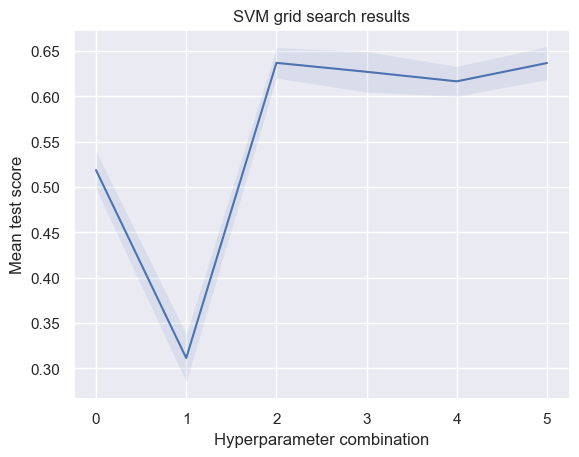

Random Forest:
Best parameters: {'n_estimators': 100}
Best score: 0.66
Test score: 0.68


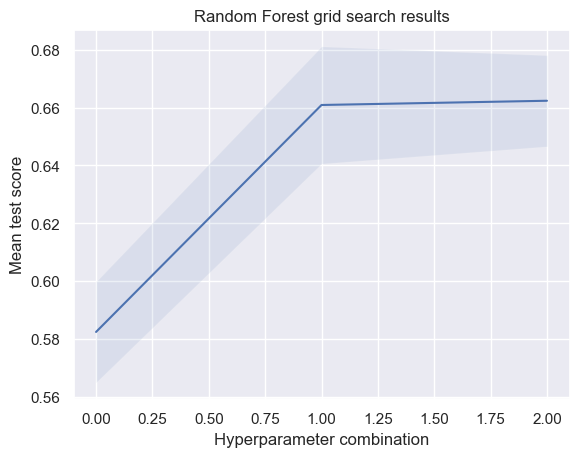

Logistic Regression:
Best parameters: {'C': 1}
Best score: 0.63
Test score: 0.64


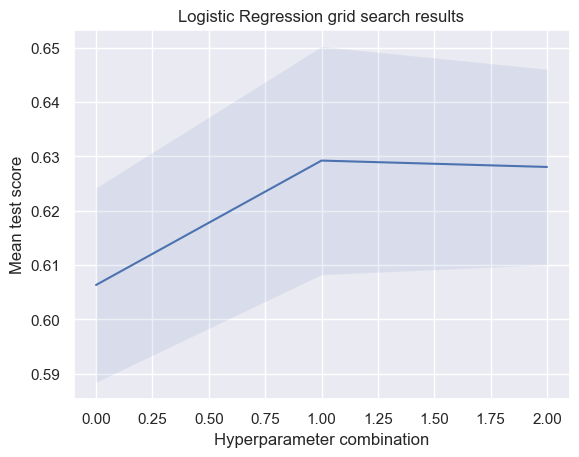

In [307]:
import warnings

warnings.filterwarnings('ignore')

# Creating a list of models to test
models = [
    {'name': 'SVM', 'model': SVC()},
    {'name': 'Random Forest', 'model': RandomForestClassifier()},
    {'name': 'Logistic Regression', 'model': LogisticRegression()},
]

# Creating a list of hyperparameter grids to search over
param_grids = [
    {'model': SVC(), 'param_grid': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}},
    {'model': RandomForestClassifier(), 'param_grid': {'n_estimators': [10, 50, 100]}},
    {'model': LogisticRegression(), 'param_grid': {'C': [0.1, 1, 10]}},
]

# Looping over the models and hyperparameter grids
for model_dict, param_grid in zip(models, param_grids):
    np.random.seed(123)
    # Extract the model and parameter grid
    model = model_dict['model']
    param_grid = param_grid['param_grid']
    
    # Creating the grid search object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    
    # Fitting the grid search object to the training data
    grid_search.fit(X_train_vec, y_train)
    
    # Printing the best parameters and best score
    print(f'{model_dict["name"]}:')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_:.2f}')
    
    # Evaluating the model on the test set
    test_score = grid_search.score(X_test_vec, y_test)
    print(f'Test score: {test_score:.2f}')
    
    # Extract the results of the grid search
    results = grid_search.cv_results_
    
    # Extract the mean and standard deviation of the test scores for each combination of hyperparameters
    means = results['mean_test_score']
    stds = results['std_test_score']
    
    # Plot the mean test scores for each combination of hyperparameters
    sns.lineplot(x=range(len(means)), y=means)
    
    # Add the standard deviation as error bars
    plt.fill_between(range(len(means)), means - stds, means + stds, alpha=0.1)
    
    # Add labels and show the plot
    plt.xlabel('Hyperparameter combination')
    plt.ylabel('Mean test score')
    plt.title(f'{model_dict["name"]} grid search results')
    plt.show()


**4. Analysis of the results**

The Random Forest classifier with 100 estimators achieved the best results among all the models and hyperparameters, both in terms of training and test performance. The model had an f1 score of 68% on the test data in a 5-fold cross-validation, which is a good starting score indicating that it was able to accurately predict the class of the text data with 68% precision and recall.

In addition, the SVM model had the lowest standard error among all the models, indicating that its performance was relatively consistent across different hyperparameter combinations and that it may be less sensitive to the specific values of its hyperparameters.

Furthermore, the Logistic Regression and SVM models performed almost identically at their best parameters, with an f1 score of 64% for the test data. This suggests that either model may be suitable for text classification, depending on the specific requirements and constraints of the project.

To improve the model, we could consider adding additional variables such as collocations (bi-grams and tri-grams) and the "year" variable, which may provide additional information to help the model make more accurate predictions. However, it is important to keep in mind that adding more variables may also increase the complexity of the model and potentially lead to overfitting. It is always a trade-off between model simplicity and performance. In this case, since the challenge was to use only the text as input, the results using a single input variable is still interesting and should not be discounted.

Overall, the models perform well and better than the minimum 50% random benchmark. Furthermore, the risk of overfitting has been avoided, as the training and test scores do not deviate significantly for any of the models. The range of f1 scores varies with just 0.04 and this implies that adding features instead of testing on other similar models would be more bountiful.

## Question 4.2 

The classification of the new lyrics is based on the optimal logistic regression model localised above. The reason for chosing this model is its interpretability. These insights from the model are are combined to inform what features in the lyrics are of importance for determining the label (pop/no-pop). The code performing this analysis is inspirered and altered from the data manual: https://jveerbeek.gitlab.io/data-mining/classification/regression.html

In [308]:
# Creating and fitting the best version of the Logistic Regression model from above with the optimal hyperparameters

lr = LogisticRegression(C=1)

lr.fit(X_train_vec, y_train)

LogisticRegression(C=1)

In [309]:
# Vectorize the original column X (containing all text)
vocabulary = vectorizer.get_feature_names()

# Get the LR weights
regression_coefficients = lr.coef_[0] 

# Combine the two lists
vocab_coef_combined = list(zip(regression_coefficients, vocabulary)) 

# Create a data frame with n
feature_importance = pd.DataFrame(vocab_coef_combined,
                      columns=['coef', 'word'])
feature_importance.sort_values('coef', ascending=False).head(10)

,coef,word
13193,2.593603,ooh
11105,2.202849,love
3206,1.615223,christmas
7717,1.585049,girl
8521,1.582044,heart
17897,1.551077,stop
19577,1.473893,uh
4151,1.469926,crazy
11118,1.418543,lover
6265,1.359462,everyday


The results above showcase that words that determine pop songs are more light in their tone. This make sense, as pop songs often have themes such as love, friendship and celebration (). The top words 'ooh' and 'love' are a good example of such themes.

In [310]:
# Calling the new lyric 
new_lyric = "The sky breaks open and the rain falls down Oh, and the pain is blinding But we carry on... Seems like the end of everything When the one you love Turns their back on you And the whole world falls down on you... It's the end of the world It's the end of the world Well, I'm holding on...But the world keeps dragging me down... It's the end of the world It's the end of the world Well, I'm holding on... But the world keeps dragging me down... I got my heart on lockdown And my eyes on the lookout But I just know that I'm Never gonna win this They can keep the lights on They can keep the music loud I don't need anything When I got my music And I'm holding on... The sky breaks open and the rain falls down And the pain is blinding But we carry on (They tell you lies) I'm holding on... (They tell you lies)The sky breaks open and the rain falls down Oh, and the pain is blinding But we carry on... Seems like the end of everything When the one you love Turns their back on you And the whole world falls down on you... It's the end of the world It's the end of the world Well, I'm holding on...But the world keeps dragging me down... It's the end of the world It's the end of the world Well, I'm holding on... But the world keeps dragging me down... I got my heart on lockdown And my eyes on the lookout But I just know that I'm Never gonna win this They can keep the lights on They can keep the music loud I don't need anything When I got my musicAnd I'm holding on... The sky breaks open and the rain falls down And the pain is blinding But we carry on (They tell you lies) I'm holding on... (They tell you lies)"

In [311]:
# Creating a data frame to use the preprocessing steps as per the original songs data frame
new_lyric = ["The sky breaks open and the rain falls down Oh, and the pain is blinding But we carry on... Seems like the end of everything When the one you love Turns their back on you And the whole world falls down on you... It's the end of the world It's the end of the world Well, I'm holding on...But the world keeps dragging me down... It's the end of the world It's the end of the world Well, I'm holding on... But the world keeps dragging me down... I got my heart on lockdown And my eyes on the lookout But I just know that I'm Never gonna win this They can keep the lights on They can keep the music loud I don't need anything When I got my music And I'm holding on... The sky breaks open and the rain falls down And the pain is blinding But we carry on (They tell you lies) I'm holding on... (They tell you lies)The sky breaks open and the rain falls down Oh, and the pain is blinding But we carry on... Seems like the end of everything When the one you love Turns their back on you And the whole world falls down on you... It's the end of the world It's the end of the world Well, I'm holding on...But the world keeps dragging me down... It's the end of the world It's the end of the world Well, I'm holding on... But the world keeps dragging me down... I got my heart on lockdown And my eyes on the lookout But I just know that I'm Never gonna win this They can keep the lights on They can keep the music loud I don't need anything When I got my musicAnd I'm holding on... The sky breaks open and the rain falls down And the pain is blinding But we carry on (They tell you lies) I'm holding on... (They tell you lies)"]

new_lyric = pd.DataFrame(new_lyric, columns = ['lyrics'])

# New frame looks good
new_lyric

,lyrics
0,"The sky breaks open and the rain falls down Oh, and the pain is blinding But we carry on... Seems like the end of everything When the one you love Turns their back on you And the whole world falls down on you... It's the end of the world It's the end of the world Well, I'm holding on...But the world keeps dragging me down... It's the end of the world It's the end of the world Well, I'm holding on... But the world keeps dragging me down... I got my heart on lockdown And my eyes on the lookout..."


In [312]:
# Preprocessing the lyric

# Cleaning the column
new_lyric['clean_lyrics'] = new_lyric['lyrics'].apply(clean_text)

# Create the lemmatized column with the words of interest with the apply() method
new_lyric['lyrics_lem'] = new_lyric['clean_lyrics'].apply(get_words_lemm)

# Create a new column containing only the nouns as a single string
new_lyric['lyrics_lem_string'] = new_lyric['lyrics_lem'].apply(lambda x: ' '.join(x))

new_lyric_test = vectorizer.transform(new_lyric['lyrics_lem_string'])

In [313]:
# Inspecting the data fraem with the new lyrics, looks good and ready for predicition
new_lyric

,lyrics,clean_lyrics,lyrics_lem,lyrics_lem_string
0,"The sky breaks open and the rain falls down Oh, and the pain is blinding But we carry on... Seems like the end of everything When the one you love Turns their back on you And the whole world falls down on you... It's the end of the world It's the end of the world Well, I'm holding on...But the world keeps dragging me down... It's the end of the world It's the end of the world Well, I'm holding on... But the world keeps dragging me down... I got my heart on lockdown And my eyes on the lookout...",the sky breaks open and the rain falls down oh and the pain is blinding but we carry on seems like the end of everything when the one you love turns their back on you and the whole world falls down on you its the end of the world its the end of the world well im holding onbut the world keeps dragging me down its the end of the world its the end of the world well im holding on but the world keeps dragging me down i got my heart on lockdown and my eyes on the lookout but i just know that im ne...,"[sky, break, open, rain, pain, back, world, world, world, world, world, world, world, heart, lockdown, eye, lookout, win, light, music, loud, music, sky, break, open, rain, pain, sky, break, open, rain, pain, back, world, world, world, world, world, world, world, heart, lockdown, eye, lookout, win, light, music, loud, musicand, sky, break, open, rain, pain, lie]",sky break open rain pain back world world world world world world world heart lockdown eye lookout win light music loud music sky break open rain pain sky break open rain pain back world world world world world world world heart lockdown eye lookout win light music loud musicand sky break open rain pain lie


In [314]:
# Calling the prediction with the processed text
new_example = ['The probability for it being a pop song is']

# Predicting probabilities for each outcome with the logistic regression model
prediction_probabilities = lr.predict_proba(new_lyric_test)
for i, proba in enumerate(prediction_probabilities):
    probability_not_pop = proba[0]
    probability_pop = proba[1]
    print("{}: {}% not pop; {}% pop".format(new_example[i], 
                                                    round(probability_not_pop, 3),
                                                    round(probability_pop, 3)))

The probability for it being a pop song is: 0.45% not pop; 0.55% pop


The probability is right on the edge between the two classification. What is clear, however, is that it would classify the song as a pop song with a 50/50-threshold.

**To what extent can these be considered as a “stereotypical” pop-song in your dataset? Provide an answer based on the results of relevant data analyses and the lyrics themselves**

Based on the data and lyrics provided, this song exhibits several characteristics that are commonly associated with pop music, including the use of words such as "love," "girl," and "crazy." These words have high coefficients in the logistic regression model, which suggests that they are strongly correlated with the classification of the song as a pop song. This is further supported by the model's probabilities, which favour the pop-song classification with 55%.

However, it's worth noting that the lyrics of a song do not always accurately reflect its genre, and a song can contain elements from multiple genres. In this case, the song's overall tone is sombre, with lyrics such as "end" (of the world), "never," and "lockdown." Using bi- and trigrams could help the model better understand the context of these words, as "never love again" would not seem to fit with the model's interpretation of the word "love" as a typical pop song theme (Bekkerman & Allan, 2004).

Additionally, the concept of a "stereotypical" pop song is subjective and can vary from person to person (Jenkins & Shattuc, 2003). Therefore, it's difficult to determine with certainty the extent to which this song can be considered a "stereotypical" pop song based solely on the data and lyrics provided. It's also important to consider the context in which the song was produced, as what was considered a pop song 30 years ago may not necessarily be classified as such today.

In my personal opinion, I would classify this song as a mix between pop and something else. Pop is one of the most diverse music genres, with a long list of subgenres due to its longevity within in music. For example, while the above song lyrics do contain pop elements, the song's overall theme and tone are more serious and sombre. A label like "sad pop" might be more fitting in terms of the song's lyrics and overall mood.

_____

***Bibliography***

    Aman, S., & Szpakowicz, S. (2007, September). Identifying expressions of emotion in text. In International Conference on Text, Speech and Dialogue (pp. 196-205). Springer, Berlin, Heidelberg.

    Bekkerman, R., & Allan, J. (2004). Using bigrams in text categorization (pp. 1-10). Technical Report IR-408, Center of Intelligent Information Retrieval, UMass Amherst.

    Blei, D. M., & Lafferty, J. D. (2006, June). Dynamic topic models. In Proceedings of the 23rd international conference on Machine learning (pp. 113-120).

    Bo-eun, Kim - 2022: https://www.scmp.com/economy/china-economy/article/3168671/chinas-fintech-ecosystem-worlds-largest-will-beijings-tech
    
    Chau, J., & Vanderwees, C. (2019). Introduction—High Fantasy, Political Dreams, and the Mainstream: Reflections on Game of Thrones. Canadian review of American studies, 49(1), 1-6.

    Chawda, S., Patil, A., Singh, A., & Save, A. (2019, April). A novel approach for clickbait detection. In 2019 3rd International Conference on Trends in Electronics and Informatics (ICOEI) (pp. 1318-1321). IEEE.
    
    Chen, M. S., Han, J., & Yu, P. S. (1996). Data mining: an overview from a database perspective. IEEE Transactions on Knowledge and data Engineering, 8(6), 866-883.
    
    Chen, X., Xu, L., Liu, Z., Sun, M., & Luan, H. (2015, June). Joint learning of character and word embeddings. In Twenty-fourth international joint conference on artificial intelligence.
    
    Chesbrough, E. A. (2012). Freedom of speech through the looking glass: reflections on the governance of political discourse in china, the United States, and the european union.
    
    Choi, D., Han, J., Chung, T., Ahn, Y. Y., Chun, B. G., & Kwon, T. T. (2015, November). Characterizing conversation patterns in reddit: From the perspectives of content properties and user participation behaviors. In Proceedings of the 2015 acm on conference on online social networks (pp. 233-243).
    
    Dumais, S. T. (2004). Latent semantic analysis. Annu. Rev. Inf. Sci. Technol., 38(1), 188-230.
    
    Entman R. M. (1993) ‘Framing: Toward Clarification of a Fractured Paradigm’. Journal of Communication 43(4): 51–58.
    
    Frigui, H., & Krishnapuram, R. (1999). A robust competitive clustering algorithm with applications in computer vision. Ieee transactions on pattern analysis and machine intelligence, 21(5), 450-465.
    
    Garcia, J. J. M., Colodro-Conde, L., Barlow, F., & Medland, S. (2022). Scientific clickbait: Examining media coverage and readability in genome-wide association research.
    
    Gentzkow, M., Kelly, B., & Taddy, M. (2019). Text as data. Journal of Economic Literature, 57(3), 535-74.
    
    Hartigan, J. A., & Wong, M. A. (1979). Algorithm AS 136: A k-means clustering algorithm. Journal of the royal statistical society. series c (applied statistics), 28(1), 100-108.
    
    Heidenreich, T., Lind, F., Eberl, J. M., & Boomgaarden, H. G. (2019). Media framing dynamics of the ‘European refugee crisis’: A comparative topic modelling approach. Journal of Refugee Studies, 32(Special_Issue_1), i172-i182.
    
    Ikonomakis, M., Kotsiantis, S., & Tampakas, V. (2005). Text classification using machine learning techniques. WSEAS transactions on computers, 4(8), 966-974.
    
    Indurthi, V., Syed, B., Gupta, M., & Varma, V. (2020, December). Predicting clickbait strength in online social media. In Proceedings of the 28th International Conference on Computational Linguistics (pp. 4835-4846).
    
    Jacobi C., Van Atteveldt W., Welbers K. (2016) ‘Quantitative Analysis of Large Amounts of Journalistic Texts Using Topic Modelling’. Digital Journalism 4(1): 89–106.
    
    Jenkins, H., McPherson, T., & Shattuc, J. (2003). Defining popular culture. In Hop on pop (pp. 26-42). Duke University Press.
    
    Joulin, A., Grave, E., Bojanowski, P., & Mikolov, T. (2016). Bag of tricks for efficient text classification. arXiv preprint arXiv:1607.01759.
    
    Klingert, Liv - 2021: https://www.politico.eu/article/lithuania-china-phones-cybersecurity-concerns/
    
    Lancaster, H. O., & Seneta, E. (2005). Chi‐square distribution. Encyclopedia of biostatistics, 2.
    
    Larres, K. (2020). Trump’s trade wars: America, China, Europe, and global disorder. Journal of Transatlantic Studies, 18(1), 103-129.
    
    Li, B., Zhao, Z., Liu, T., Wang, P., & Du, X. (2016, December). Weighted neural bag-of-n-grams model: New baselines for text classification. In Proceedings of COLING 2016, the 26th International Conference on Computational Linguistics: Technical Papers (pp. 1591-1600).
    
    Medhat, W., Hassan, A., & Korashy, H. (2014). Sentiment analysis algorithms and applications: A survey. Ain Shams engineering journal, 5(4), 1093-1113.
    
    Mello, R. A. (2002). Collocation analysis: A method for conceptualizing and understanding narrative data. Qualitative research, 2(2), 231-243.
    
    Nyuytiymbiy, K., (2020). Parameters and Hyperparameters in Machine Learning and Deep Learning. Towards Data Science.
    
    Onan, A., Korukoglu, S., & Bulut, H. (2016). LDA-based Topic Modelling in Text Sentiment Classification: An Empirical Analysis. Int. J. Comput. Linguistics Appl., 7(1), 101-119.
    
    Scacco, J. M., & Muddiman, A. (2016). Investigating the influence of “clickbait” news headlines. Engaging News Project Report.
    
    Sepinwall, A. (2013). The revolution was televised: How The Sopranos, Mad Men, Breaking Bad, Lost, and other groundbreaking dramas changed TV forever. Simon and Schuster.
    
    Shuai, Y., Zheng, Y., & Huang, H. (2018, November). Hybrid software obsolescence evaluation model based on PCA-SVM-GridSearchCV. In 2018 IEEE 9th international conference on software engineering and service science (ICSESS) (pp. 449-453). IEEE.
    
    Shukla, S., & Naganna, S. (2014). A review on K-means data clustering approach. International Journal of Information and Computation Technology, 4(17), 1847-1860.
    
    Sidorov, G., Velasquez, F., Stamatatos, E., Gelbukh, A., & Chanona-Hernández, L. (2014). Syntactic n-grams as machine learning features for natural language processing. Expert Systems with Applications, 41(3), 853-860.
    Tong, Z., & Zhang, H. (2016, May). A text mining research based on LDA topic modelling. In International conference on computer science, engineering and information technology (pp. 201-210).
    
    Van Dijk, T. A. (2015). Critical discourse analysis. The handbook of discourse analysis, 466-485.
    
    Wei, W. W. (2013). Time series analysis.
    
    Xu, S., Jaiswal, A., Zhang, X., Klippel, A., Mitra, P., & MacEachren, A. M. (2010, December). From data collection to analysis—exploring regional linguistic variation in route directions by spatially-stratified web sampling. In Computational Models of Spatial Language Interpretation (CoSLI) Workshop at Spatial Cognition (pp. 49-52).
    
    Yuan, X., Chen, J., Zhang, K., Wu, Y., & Yang, T. (2021). A stable ai-based binary and multiple class heart disease prediction model for IoMT. IEEE Transactions on Industrial Informatics, 18(3), 2032-2040.
    
    Yun, J., Lee, J., Shon, H., Yi, E., Kim, S. H., & Kim, J. (2022). On the Angular Update and Hyperparameter Tuning of a Scale-Invariant Network. In European Conference on Computer Vision (pp. 121-136). Springer, Cham.
    
    Zhang, W., & Chib, A. (2014). Internet studies and development discourses: The cases of China and India. Information Technology for Development, 20(4), 324-338.
    
    Zuhroh, N. A., & Rakhmawati, N. A. (2020). Clickbait detection: A literature review of the methods used. Register: Jurnal Ilmiah Teknologi Sistem Informasi, 6(1), 1-10.

**End of assignment**